# Data Preparation

In [21]:
#knitr::purl(here("Rmd/childcare_article_analyses.Rmd"), here("R/childcare_article_analyses.R"))

In [2]:
library(vegan)
library(microbiome)
library(tidyverse)
library(here)
library(future)
library(furrr)
library(broom)
library(ggpubr)
library(patchwork)
library(brms)

In [10]:
# load data and helper functions
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/bayesian_helper.R")
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/mb_helper.R")
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/reporting.R")

In [11]:
load(here("data/data_transfer.RData"))
source(here("R/read.R"))

In [12]:
# take over the meta variables I created in other docs
meta_new <- data_transfer[, 1:9] 

In [13]:
# create catories for bf and childcare and specifically for ccyes vs rest
meta_new <- meta_new %>%
  mutate(
      groups = ifelse(time == "pre" & cc == "no", "noCCpre", ifelse(
          time == "pre" & cc == "yes", "CCpre", ifelse(
              time == "post" & cc == "no", "noCCpost", "CCpost"))),
      bf = ifelse(bf_ratio <= 0.25, "lowBF", ifelse(
          bf_ratio <0.75, "mediumBF", "highBF")),
      ccpost = ifelse(groups == "CCpost", 1, 0)) %>% 
  mutate(
      groups = as.factor(groups), 
      bf = as.factor(bf), 
      ccpost = as.factor(ccpost))

In [14]:
siblings <- readxl::read_excel(here("data/meta_data/siblings_addon_yvonne.xlsx")) %>% 
    filter(subject_id %in% meta_new$subject_id)
siblings[siblings$subject_id == 453, "sibling"] <- 2

In [15]:
# add confounding variables
confounders <- foreign::read.spss(here("data/meta_data/bibo_confounders.sav"), to.data.frame = T) %>%
    select(subject_id = ID, childsex, delivery = DELIVERYmode, birthweight = BIRTHWEIGTH) %>%
    filter(subject_id %in% meta_new$subject_id) %>% 
    left_join(siblings, by = "subject_id") %>% 
    mutate(
        sibling = ifelse(sibling == 0, 0, ifelse(sibling >= 1, 1, NA)),
        csection = ifelse(
        delivery == "natuurlijke bevalling", 0,
            ifelse(delivery == "6", NA, 
               ifelse(delivery == "999", NA,
                      ifelse(delivery == "pomp", 0, 1)))))
meta_new <- meta_new %>% left_join(confounders, by = "subject_id")

Warning message in foreign::read.spss(here("data/meta_data/bibo_confounders.sav"), :
“Undeclared level(s) 2 added in variable: SIBLINGS”Warning message in foreign::read.spss(here("data/meta_data/bibo_confounders.sav"), :
“Undeclared level(s) 6, 999 added in variable: DELIVERYmode”

In [18]:
# create new pseq object (read.R results in the object "genus" Leo created)
otu <- otu_to_df(genus, transpose = FALSE)
otu <- otu %>% 
    select(species, meta_new$sample_id) %>% 
    df_to_otu()
pseq <- phyloseq(otu, df_to_sd(meta_new), tax_table(genus))
# add diversity indeces to sample data
diversities <- 
    global(pseq, index = "all") %>% 
    select(contains("diversities")) %>% 
    rownames_to_column("sample_id")
colnames(diversities) <- gsub("diversities_", "", colnames(diversities))

sample_data(pseq) <- 
    sd_to_df(pseq) %>% 
    left_join(diversities, by = "sample_id") %>%
    df_to_sd()
meta <- sd_to_df(pseq)
# clr and relative abundance transformation to deal with compositionality of mb data
pseq.clr <- microbiome::transform(pseq, transform = "clr")
pseq.rel <- microbiome::transform(pseq, "compositional")

Richness
Observed (richness 0)
Diversity
Evenness
Dominance
Rarity
Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

# PCA

A PCA using CLR transformed values displays the Aitchison distance.

In [19]:
otus.clr <- otu_to_df(pseq.clr)
colnames(otus.clr)[which(colnames(otus.clr) == "Clostridium \\(sensu stricto\\)")] <- "Clostridium_sensu_stricto"
colnames(otus.clr) <- c("sample_id", gsub("_", "", colnames(otus.clr)[-1]))
colnames(otus.clr) <- gsub("\\.", "", colnames(otus.clr))
colnames(otus.clr) <- gsub(" ", "", colnames(otus.clr))
genus <- colnames(otus.clr)[-1]
data <- sd_to_df(pseq.clr) %>%
    left_join(otus.clr, by = "sample_id")
data$childsex <- as.factor(data$childsex)
data$delivery <- as.factor(data$delivery)
data <- data %>% mutate(birthweight_s = scale(birthweight)[, 1])


# PCA with CLR values (euclidean distance of clr transformed values = Aitchison distance) 
pcx <- prcomp(otus.clr %>% column_to_rownames("sample_id"))
pcr <- FactoMineR::PCA(otus.clr %>% column_to_rownames("sample_id"), scale.unit = F)
# extract loadings
pcx_rot <- 
    pcx$rotation %>%
        as.tibble() %>%
        mutate_all(function(x) x*10) %>%
        add_column(genus = rownames(pcx$rotation))

# add PCs to data
princomps <- pcx$x %>% as.data.frame() %>%
    rownames_to_column("sample_id") %>%
    select(PC1, PC2, PC3, PC4, PC5, sample_id)
data <- data %>% left_join(princomps, by = "sample_id") 
                   
# how much variance do pcs explain?
pc1 <- round(pcx$sdev[1]^2/sum(pcx$sdev^2),2)
pc2 <- round(pcx$sdev[2]^2/sum(pcx$sdev^2),2)
pc3 <- round(pcx$sdev[3]^2/sum(pcx$sdev^2),2)
pc4 <- round(pcx$sdev[4]^2/sum(pcx$sdev^2),2)
pc5 <- round(pcx$sdev[5]^2/sum(pcx$sdev^2),2)                   

Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”Warning message:
“`as.tibble()` is deprecated, use `as_tibble()` (but mind the new semantics).
This warning is displayed once per session.”

Warning message:
“Calling `as_tibble()` on a vector is discouraged, because the behavior is likely to change in the future. Use `enframe(name = NULL)` instead.
This warning is displayed once per session.”

PC,eigenvalue,variance.percent,cumulative.variance.percent
Dim.1,7.492345,18.302690,18.30269
Dim.2,6.825044,16.672574,34.97526
Dim.3,5.170574,12.630948,47.60621
Dim.4,2.653409,6.481886,54.08810
Dim.5,2.331739,5.696093,59.78419
Dim.6,1.928572,4.711216,64.49541
Dim.7,1.527073,3.730413,68.22582
Dim.8,1.306151,3.190733,71.41655
Dim.9,1.150518,2.810546,74.22710


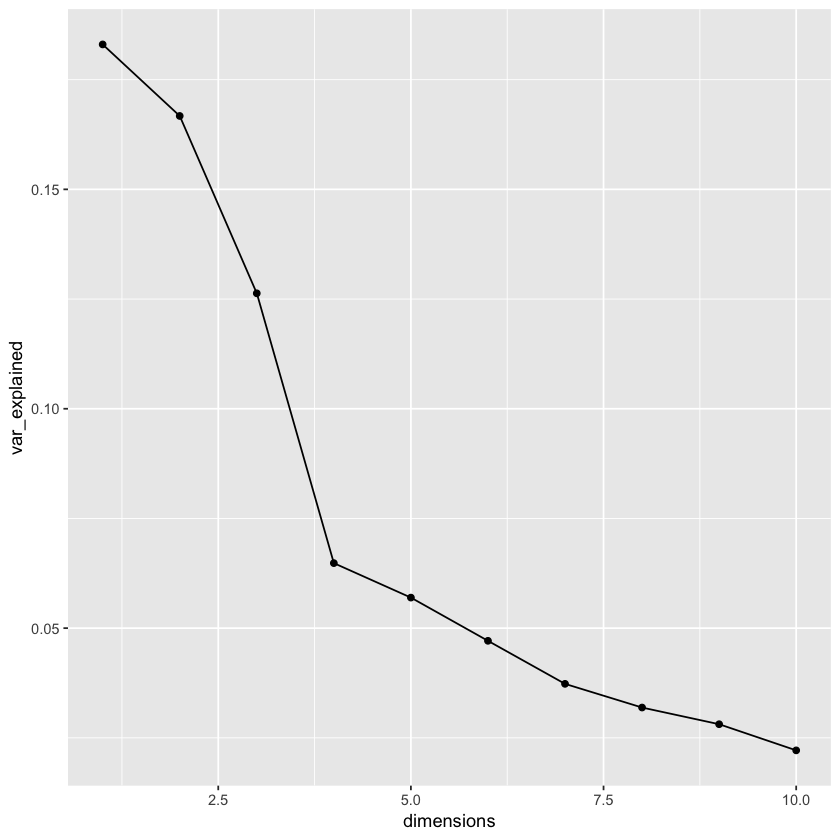

In [20]:
# screeplot
pcx$sdev %>% as_tibble() %>%
  mutate(
    var_explained = value^2/sum(pcx$sdev^2), 
    dimensions = 1:length(pcx$sdev)) %>%
    filter(dimensions <= 10) %>%
  ggplot(aes(dimensions, var_explained)) +
  geom_point() +
  geom_line()
# Kaiser guttman rule
factoextra::get_eigenvalue(pcx) %>% 
    rownames_to_column("PC")  %>% 
    filter(eigenvalue > 1)

In [21]:
#paran::paran(otus.clr %>% column_to_rownames("sample_id"), graph = T)

In [22]:
map(pcr$var, ~.x %>% 
    as.data.frame() %>% 
    rownames_to_column("genus") %>% 
    filter(genus %in% c("Bifidobacterium", "Streptococcusmitisetrel", "Streptococcusintermediusetrel", "Streptococcusbovisetrel", "Enterococcus", "Granulicatella")))

genus,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5
Bifidobacterium,0.23689943,-0.8430893,0.2693419,-0.16912210,0.249467825
Enterococcus,0.55458801,1.3421055,0.3973913,0.20342628,-0.014472791
Granulicatella,0.51417384,1.6883808,0.1769194,0.25297255,-0.006640859
Streptococcusbovisetrel,0.02317298,0.2384418,-1.2113909,-0.10642283,-0.078635418
Streptococcusintermediusetrel,-0.05479749,0.1293704,-0.7574678,0.02323414,0.011588314
Streptococcusmitisetrel,-0.19911512,0.1019484,-1.2281208,-0.07736597,0.086802910
genus,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5
Bifidobacterium,0.17030849,-0.60610220,0.19363158,-0.12158294,0.17934399
Enterococcus,0.33920445,0.82087633,0.24305771,0.12442227,-0.00885204
Granulicatella,0.27616235,0.90682793,0.09502324,0.13587135,-0.00356680


In [23]:
p_versions <- c(1:4)
# just to compare with others:
#stats::biplot(pcx)
# biplots
biplot_cc <- biplot(pseq.clr, color = "cc", split_by = "time")
map2(biplot_cc, p_versions, ~ggsave(plot = .x, filename = here(glue("fig/aitchison_pca_cc_{.y}.png"))))
biplot_time <- biplot(pseq.clr, split_by = "cc", connect_series = "time")
map2(biplot_time, p_versions, ~ggsave(plot = .x, filename = here(glue("fig/aitchison_pca_time_{.y}.png"))))
biplot_csection <- biplot(pseq.clr, color = "csection")
biplot_sibling <- biplot(pseq.clr, color = "sibling")

Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”Warning message:
“group_by_() is deprecated. 
Please use group_by() instead

The 'programming' vignette or the tidyeval book can help you
to program with group_by() : https://tidyeval.tidyverse.org
This warning is displayed once per session.”Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image


[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”Warning message:
“arrange_() is deprecated. 
Please use arrange() instead

The 'programming' vignette or the tidyeval book can help you
to program with arrange() : https://tidyeval.tidyverse.org
This warning is displayed once per session.”Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image


[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

Warning message:
“Removed 4 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing missing values (geom_point).”

[[1]]

[[2]]


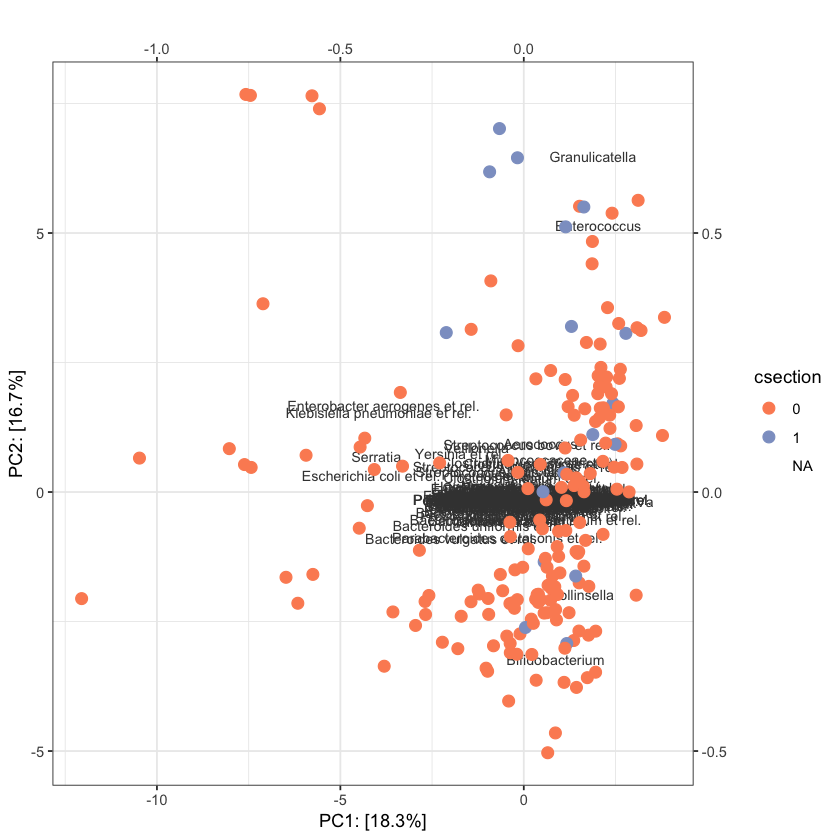

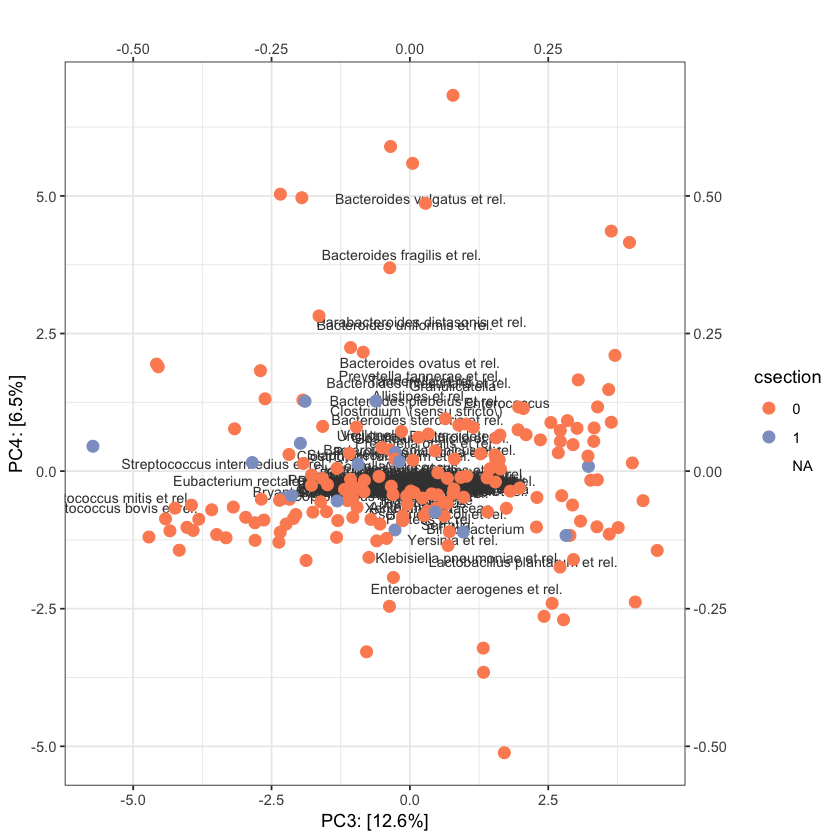

In [24]:
biplot_csection

# Multiple Impuation

In [26]:
# I recode the contrasts so that I have the comparisons I want:
# the intercept will reflect our group we want to compare to others (cc post)
# the cc coefficient then compares to no cc post, the time coefficent 
# to cc pre and the interaction to no cc pre
# contrasts(data$cc)[1, 1] <- 1
# contrasts(data$cc)[2, 1] <- 0
# contrasts(data$time)[1, 1] <- 1
# contrasts(data$time)[2, 1] <- 0

library(mice)
# Next I impute data using predictive mean matching (PMM). PMM is
# less difficult to specify. I use the PCs to impute instead of all 
# genus abundances since these are correlated
data_imp <- data %>% 
    select(
        -everything(), 
        subject_id, 
        age_d_s, 
        time, 
        cc, 
        bf_count_s, 
        sibling,
        birthweight_s,
        csection,
        PC1,
        PC2,
        PC3,
        PC4,
        PC5) %>%
    mice(m = 10, method = "pmm", print = F, seed = 412) %>%
    mice::complete("all")
# This I use to join genus abundances again
deselect_col <- colnames(data_imp[[1]])
data_lj <- data %>% select(-deselect_col, subject_id, time)
data_imp <- map(data_imp, ~.x %>% left_join(data_lj, by = c("subject_id", "time")))

In [27]:
# PMM does not understand that for one subject the sibling/csection must be similar, so I manually always use the pre
# sibling which is random.
data_imp <- map(data_imp, function(x) {
    #x[x$subject_id == "453" & x$time == "post", "sibling"] <- x[x$subject_id == "453" & x$time == "pre", "sibling"]
    csection_pre_449 <- x[x$subject_id == 449 & x$time == "pre", "csection"]
    csection_pre_369 <- x[x$subject_id == 369 & x$time == "pre", "csection"]
    x <- x %>% mutate(
        csection = ifelse(subject_id == "449", csection_pre_449, 
                          ifelse(subject_id == "369", csection_pre_369, csection)),
        sibling = as.factor(sibling),
        csection = as.factor(csection)
        
    )

})

In [28]:
# for the PERMAONVA I exchange the levels of csection because the output shows the opposite direction for some reason
data_imp_pm <- map(data_imp, function(x) {
    x <- x %>% mutate(
        csection = ifelse(csection == 0, 1, 0), 
        csection = as.factor(csection),
        sibling = ifelse(sibling == 0, 1, 0),
        sibling = as.factor(sibling), 
        time = as.numeric(time),
        time = ifelse(time == 2, 0, time),
        time = as.factor(time),
        cc = as.numeric(cc),
        cc = ifelse(cc == 2, 0, cc),
        cc = as.factor(cc)
    )

})

In [29]:
data_imp_pm$`1` %>% head()
data_imp$`1` %>% head()

subject_id,age_d_s,time,cc,bf_count_s,sibling,birthweight_s,csection,PC1,PC2,⋯,UnculturedClostridialesI,UnculturedClostridialesII,UnculturedMollicutes,UnculturedSelenomonadaceae,Veillonella,Vibrio,Weissellaetrel,Wissellaetrel,Xanthomonadaceae,Yersiniaetrel
207,0.0320946,0,1,0.43948544,0,1.2879095,1,0.6522303,-5.032933,⋯,1.519156,1.372621,0.7160732,-1.927865,0.007149684,-0.10856364,-0.6791585,-1.784952,-1.1159486,-0.5359823
388,0.0320946,0,0,-1.65710371,1,0.5238208,0,2.1772289,2.222415,⋯,1.520612,1.402049,0.7529889,-1.886635,-0.427626440,-0.48058463,-0.6305414,-1.871706,-1.1036017,-0.4674306
381,0.5275689,0,0,0.64565004,1,1.7973020,1,-3.8048048,-3.362403,⋯,1.358991,1.214345,0.5915841,-2.070707,1.409813575,-0.58935158,-0.7658887,-2.065654,-1.1978397,-0.6346164
283,0.4795079,0,0,0.09005391,1,0.5238208,0,0.5556721,-1.347504,⋯,1.610124,1.466771,0.8462106,-1.808475,-0.315038020,-0.41845176,-0.6420510,-1.821146,-0.9773766,-0.3960749
216,0.1311895,0,1,0.78891696,0,-1.5774233,1,0.5538208,-2.336841,⋯,1.621011,1.462915,0.8533308,-1.818445,0.417199942,-0.39016117,-0.6681320,-1.779084,-0.9487578,-0.3955171
277,-0.9093066,1,0,0.47442859,0,-1.0468061,1,0.2194682,-3.135664,⋯,1.615525,1.462350,0.8428855,-1.878538,-0.484741093,-0.07106405,-0.6091588,-1.718924,-0.6601499,-0.2722814


subject_id,age_d_s,time,cc,bf_count_s,sibling,birthweight_s,csection,PC1,PC2,⋯,UnculturedClostridialesI,UnculturedClostridialesII,UnculturedMollicutes,UnculturedSelenomonadaceae,Veillonella,Vibrio,Weissellaetrel,Wissellaetrel,Xanthomonadaceae,Yersiniaetrel
207,0.0320946,post,no,0.43948544,1,1.2879095,0,0.6522303,-5.032933,⋯,1.519156,1.372621,0.7160732,-1.927865,0.007149684,-0.10856364,-0.6791585,-1.784952,-1.1159486,-0.5359823
388,0.0320946,post,yes,-1.65710371,0,0.5238208,1,2.1772289,2.222415,⋯,1.520612,1.402049,0.7529889,-1.886635,-0.427626440,-0.48058463,-0.6305414,-1.871706,-1.1036017,-0.4674306
381,0.5275689,post,yes,0.64565004,0,1.7973020,0,-3.8048048,-3.362403,⋯,1.358991,1.214345,0.5915841,-2.070707,1.409813575,-0.58935158,-0.7658887,-2.065654,-1.1978397,-0.6346164
283,0.4795079,post,yes,0.09005391,0,0.5238208,1,0.5556721,-1.347504,⋯,1.610124,1.466771,0.8462106,-1.808475,-0.315038020,-0.41845176,-0.6420510,-1.821146,-0.9773766,-0.3960749
216,0.1311895,post,no,0.78891696,1,-1.5774233,0,0.5538208,-2.336841,⋯,1.621011,1.462915,0.8533308,-1.818445,0.417199942,-0.39016117,-0.6681320,-1.779084,-0.9487578,-0.3955171
277,-0.9093066,pre,yes,0.47442859,1,-1.0468061,0,0.2194682,-3.135664,⋯,1.615525,1.462350,0.8428855,-1.878538,-0.484741093,-0.07106405,-0.6091588,-1.718924,-0.6601499,-0.2722814


In [40]:
# data_imp$`1`$csection <- data_imp$`1`$csection %>% as.factor()
# data_imp$`1`$sibling <- data_imp$`1`$sibling %>% as.factor()
# data_imp$`2`$csection <- data_imp$`1`$csection %>% as.factor()
# data_imp$`3`$csection <- data_imp$`2`$csection %>% as.factor()
# data_imp$`1`$csection %>% contrasts
# contrasts(data_imp$`2`$csection) <- contr.sum
# contrasts(data_imp$`2`$cc) <- contr.sum
# contrasts(data_imp$`2`$time) <- contr.sum
# data_imp$`2`$sibling <- as.factor(data_imp$`2`$sibling)
# contrasts(data_imp$`2`$sibling) <- contr.sum
# ct_object <- data_imp$`3`$csection %>% contrasts
# ct_object[1,1] <- 1
# ct_object[2,1] <- 0
# contrasts(data_imp$`3`$csection) <- ct_object
# data_imp$`3`$csection %>% contrasts 
# data_imp$`2`$csection %>% contrasts 

In [41]:
# data_imp$`4`$time <- as.numeric(data_imp$`4`$time)
# data_imp$`4`$cc <- as.numeric(data_imp$`4`$cc)
# data_imp$`4`$sibling <- as.numeric(data_imp$`4`$sibling)
# data_imp$`4` <- data_imp$`4`  %>% mutate(
#     cc = ifelse(cc == 1, 0, 1),
#     time = ifelse(time==1, 0, 1)
# )
# data_imp$`4` %>% head()

# PERMANOVA
I cannot use Bray Curtis distance for CLR transformed data. Thus I do it once with relative abundance and for clr transformed data I use Euclidean distance, which then is the Aitchison distance. I

In [30]:
# clr/euclidean
#meta.clr <- sd_to_df(pseq.clr) %>% select(-sibling) %>% na.omit()
#otus.clr <- otu_to_df(pseq.clr, transpose = F) %>% 
#    column_to_rownames("species") %>%
#    select(meta.clr$sample_id) %>%
#    t() 

# Homogeneity assumption (for sibling I use one of the imputed sets)
dist <- vegdist(otus.clr[, -1], method = "euclidean")
hg_cc <- anova(betadisper(dist, data_imp[[1]]$cc))
hg_time <- anova(betadisper(dist, data_imp[[1]]$time))
hg_groups <- anova(betadisper(dist, data_imp[[1]]$groups))
hg_childsex <- anova(betadisper(dist, data_imp[[1]]$childsex))
hg_sibling <- anova(betadisper(dist, data_imp[[1]]$sibling))
hg_csection <- anova(betadisper(dist, data_imp[[2]]$csection))
hg_sibling
hg_cc
hg_csection

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Groups,1,51.23763,51.237627,9.572915,0.002266331
Residuals,194,1038.35657,5.352353,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Groups,1,9.850609,9.850609,1.741481,0.1885064
Residuals,194,1097.352102,5.656454,NA,NA


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Groups,1,7.693679,7.693679,1.367445,0.2436862
Residuals,194,1091.505778,5.626318,NA,NA


In [31]:
fit_pm <- function(data_imp) {
    otus <- data_imp %>% 
        select(genus, sample_id) %>% 
        column_to_rownames("sample_id")
    meta <- data_imp %>% 
        select(-everything(), subject_id, sample_id, time, cc, age_d_s, bf_count_s, sibling, childsex, birthweight_s, csection) %>% 
        column_to_rownames("sample_id")
    pm <- adonis(
        otus ~ time * cc + age_d_s + bf_count_s + csection + sibling + birthweight_s, 
        method = "euclidean", 
        data =  meta)
    list(aov = pm$aov.tab, coefs = coefficients(pm))
}
plan(multiprocess)
pms <- future_map(data_imp_pm, fit_pm)

In [32]:
map(pms, ~.x$aov %>% as.data.frame())

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr(>F)
time,1,58.44386,58.44386,1.511558,0.007321524,0.097
cc,1,52.63602,52.63602,1.361347,0.006593950,0.175
age_d_s,1,79.55311,79.55311,2.057515,0.009965973,0.028
bf_count_s,1,190.28611,190.28611,4.921448,0.023837991,0.001
csection,1,139.00039,139.00039,3.595024,0.017413199,0.003
sibling,1,103.38152,103.38152,2.673799,0.012951065,0.002
birthweight_s,1,89.70390,89.70390,2.320049,0.011237609,0.015
time:cc,1,39.17630,39.17630,1.013233,0.004907790,0.414
Residuals,187,7230.29146,38.66466,NA,0.905770900,NA
Total,195,7982.47268,NA,NA,1.000000000,NA


In [33]:
pm_table <- pms[[1]]$aov %>%
    rownames_to_column("Model Parameters") %>%
    mutate_if(is.numeric, funs(round(., 3))) %>%
    mutate(
      MeanSqs = ifelse(is.na(MeanSqs), "-", MeanSqs),
      F.Model = ifelse(is.na(F.Model), "-", F.Model),
      `Pr(>F)` = ifelse(is.na(`Pr(>F)`), "-", `Pr(>F)`) 
    ) %>%
    select(`Model Parameters`,SumsOfSqs, MeanSqs, F.Model, Df,`Pr(>F)`, R2)

colnames(pm_table) <- c("Model Parameter", "Sum of Squares", "Mean Sum of Squares", "F", "Df", "p", "R Square" )
papaja::apa_table(pm_table)

Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
please use list() instead

# Before:
funs(name = f(.)

# After: 
list(name = ~f(.))
This warning is displayed once per session.”



\begin{table}[tbp]
\begin{center}
\begin{threeparttable}
\begin{tabular}{lllllll}
\toprule
Model Parameter & \multicolumn{1}{c}{Sum of Squares} & \multicolumn{1}{c}{Mean Sum of Squares} & \multicolumn{1}{c}{F} & \multicolumn{1}{c}{Df} & \multicolumn{1}{c}{p} & \multicolumn{1}{c}{R Square}\\
\midrule
time & 58.44 & 58.444 & 1.512 & 1.00 & 0.097 & 0.01\\
cc & 52.64 & 52.636 & 1.361 & 1.00 & 0.175 & 0.01\\
age\_d\_s & 79.55 & 79.553 & 2.058 & 1.00 & 0.028 & 0.01\\
bf\_count\_s & 190.29 & 190.286 & 4.921 & 1.00 & 0.001 & 0.02\\
csection & 139.00 & 139 & 3.595 & 1.00 & 0.003 & 0.02\\
sibling & 103.38 & 103.382 & 2.674 & 1.00 & 0.002 & 0.01\\
birthweight\_s & 89.70 & 89.704 & 2.32 & 1.00 & 0.015 & 0.01\\
time:cc & 39.18 & 39.176 & 1.013 & 1.00 & 0.414 & 0.00\\
Residuals & 7,230.29 & 38.665 & - & 187.00 & - & 0.91\\
Total & 7,982.47 & - & - & 195.00 & - & 1.00\\
\bottomrule
\end{tabular}
\end{threeparttable}
\end{center}
\end{table}



In [34]:
pms[[4]]$coefs

,Actinomycetaceae,Aerococcus,Aeromonas,Akkermansia,Alcaligenesfaecalisetrel,Allistipesetrel,Anaerobiospirillum,Anaerofustis,Anaerostipescaccaeetrel,Anaerotruncuscolihominisetrel,⋯,UnculturedClostridialesI,UnculturedClostridialesII,UnculturedMollicutes,UnculturedSelenomonadaceae,Veillonella,Vibrio,Weissellaetrel,Wissellaetrel,Xanthomonadaceae,Yersiniaetrel
(Intercept),-1.052935169,-1.422343261,-1.898978269,-0.78191884,-0.511950314,1.031529130,-1.883149490,-1.6063607802,0.615334553,0.588015881,⋯,1.521025588,1.422234592,0.740322334,-1.922220557,0.20256937,-0.38415559,-0.5448675438,-1.823258606,-0.978066819,-0.25277874
time1,-0.029182197,-0.001534497,0.022347591,-0.02666222,0.026819509,0.036574091,0.030660693,0.0092561228,-0.017884560,0.018755608,⋯,-0.001586204,0.007793833,0.020065497,0.018724057,-0.22587019,0.03795123,-0.0338040484,0.069162373,0.020992319,0.01174004
cc1,0.037992515,0.010921820,0.022068515,-0.06788720,0.025744021,-0.026627926,0.008268218,0.0197358595,-0.032357455,0.021194261,⋯,0.008166459,0.026335889,0.019227605,0.018484615,0.07344176,0.02360603,0.0054741589,0.058604857,0.009181630,-0.04372631
age_d_s,0.006218823,0.032510230,-0.021108063,0.08189238,-0.019084366,-0.036801808,-0.023637677,0.0009508252,0.033811425,-0.017587108,⋯,-0.016730749,-0.018340405,-0.014075283,-0.008934144,0.29014270,-0.10810625,0.0454276433,-0.132818616,-0.033744302,-0.09730440
bf_count_s,-0.038221839,-0.071378157,-0.003035965,-0.14077719,-0.009711406,0.069657655,0.019944204,-0.0326272852,-0.043575862,-0.005075110,⋯,-0.028551108,-0.005092316,-0.003532136,-0.005371650,0.15086793,-0.05344365,0.0022193234,-0.115502493,0.025871278,0.06533791
csection1,-0.075861710,0.133865862,0.004525921,0.20067391,-0.001778330,-0.028923469,-0.002252549,0.0506356515,0.021852550,0.019558979,⋯,0.004671970,0.024554192,0.010396454,0.018248228,0.11056380,-0.03326955,0.0517577716,-0.003526534,-0.069633404,-0.05966441
sibling1,0.017315715,0.015116391,0.020265924,0.12029130,0.011453549,-0.016262007,0.002632334,0.0135614004,0.009665708,0.019610608,⋯,0.030411532,0.014608391,0.022391141,0.023047422,0.00450394,-0.03242599,0.0202828005,-0.004441929,-0.003965831,-0.10986742
birthweight_s,-0.024026524,0.015605918,-0.012520173,0.03231207,0.001215476,0.053299396,0.002868051,-0.0018651332,0.009143962,-0.011441920,⋯,0.005819804,-0.005745306,-0.011203233,-0.010922586,0.10235542,-0.03021507,0.0001782807,-0.070902172,-0.007345980,0.06957728
time1:cc1,0.014783753,-0.036818241,0.012950733,0.06082394,0.023413148,-0.006633821,0.008731860,-0.0267838339,-0.009894922,0.008036072,⋯,0.022554245,0.002639587,0.009464827,0.007549196,-0.08481811,0.01065906,-0.0020290106,0.027829256,0.020779622,0.02611763


Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image


$`1`

$`2`

attr(,"class")
[1] "list"      "ggarrange"

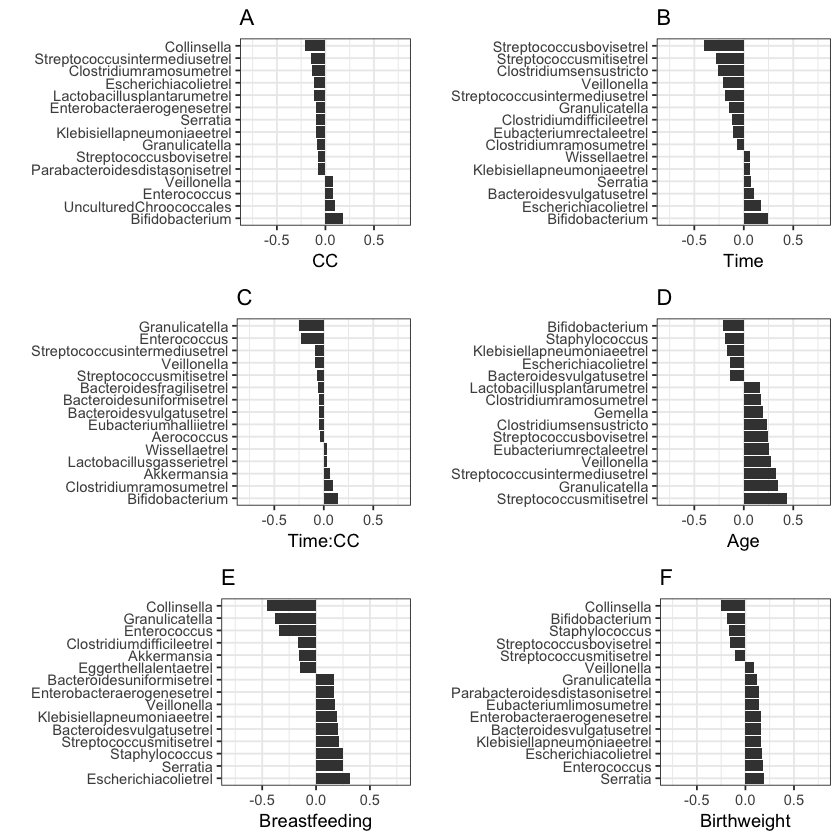

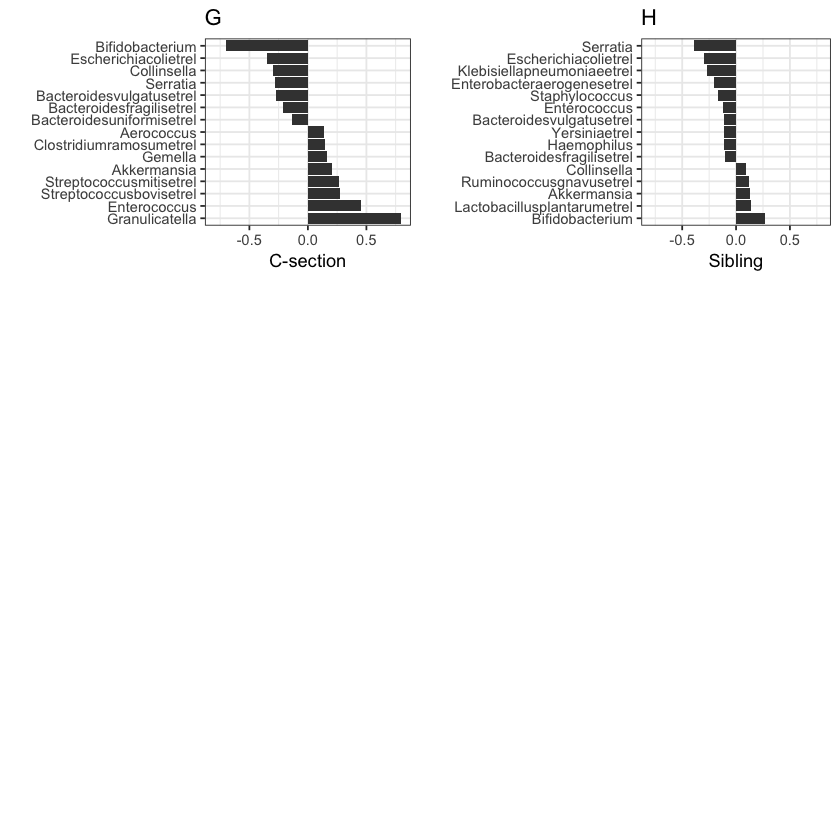

In [35]:
coef_v <- c("cc1", "time1", "time1:cc1", "age_d_s", "bf_count_s", "birthweight_s", "csection1", "sibling1")
coef_title <- c("CC", "Time", "Time:CC", "Age", "Breastfeeding", "Birthweight", "C-section", "Sibling")
pmps <- map2(coef_v, coef_title, function(.x, .y) {
    coef <- pms[[1]]$coefs[.x,] 
    # make plot that I can manipulate better for apa6th in case
    coef_top <- 
        coef[rev(order(abs(coef)))[1:15]] %>%
        as.data.frame() %>%
        rownames_to_column("top_taxa") 
    colnames(coef_top) <- c("top_taxa", "coef_top")

    coef_top <- coef_top %>% arrange(desc(coef_top)) %>%
                mutate(top_taxa = factor(top_taxa, levels = top_taxa))
     p <- ggplot(coef_top, aes(top_taxa, coef_top)) +
            geom_bar(stat="identity", fill = "#404040") +
            ylim(-0.8, 0.8) +
            xlab("") + ylab(.y) +
            ggtitle(glue::glue("Coefficient: {.x}")) +
            coord_flip() +
            theme_bw()
    ggsave(here(glue("fig/permanova_{.x}_clr.png")))
    p
})
ggpubr::ggarrange(
    pmps[[1]] + ggtitle('A'),
    pmps[[2]] + ggtitle('B'), 
    pmps[[3]] + ggtitle('C'), 
    pmps[[4]] + ggtitle('D'), 
    pmps[[5]] + ggtitle('E'), 
    pmps[[6]] + ggtitle('F'),
    pmps[[7]] + ggtitle('G'),
    pmps[[8]] + ggtitle('H'),
    #pmps[[9]] + ggtitle('I'),
    nrow = 3, ncol = 2, common.legend = T)


In [36]:
data %>% group_by(sibling, time, cc) %>% summarise(mean(Bifidobacterium), mean(Streptococcusbovisetrel))

sibling,time,cc,mean(Bifidobacterium),mean(Streptococcusbovisetrel)
0,pre,no,5.444282,4.623618
0,pre,yes,5.506419,3.842514
0,post,no,5.667908,3.694142
0,post,yes,6.183705,3.724990
1,pre,no,6.454342,3.869514
1,pre,yes,6.308297,4.497468
1,post,no,6.133263,3.713173
1,post,yes,6.474834,3.623859


# Hierarchical Generalized Linear Models

## Alpha diversity regressed on X

I started with a prior of exp(10). From my limited experience, models will converge if I use a strong prior here. The prior assigns low probability to high variation of the distribution of the intercepts and slopes per individual.

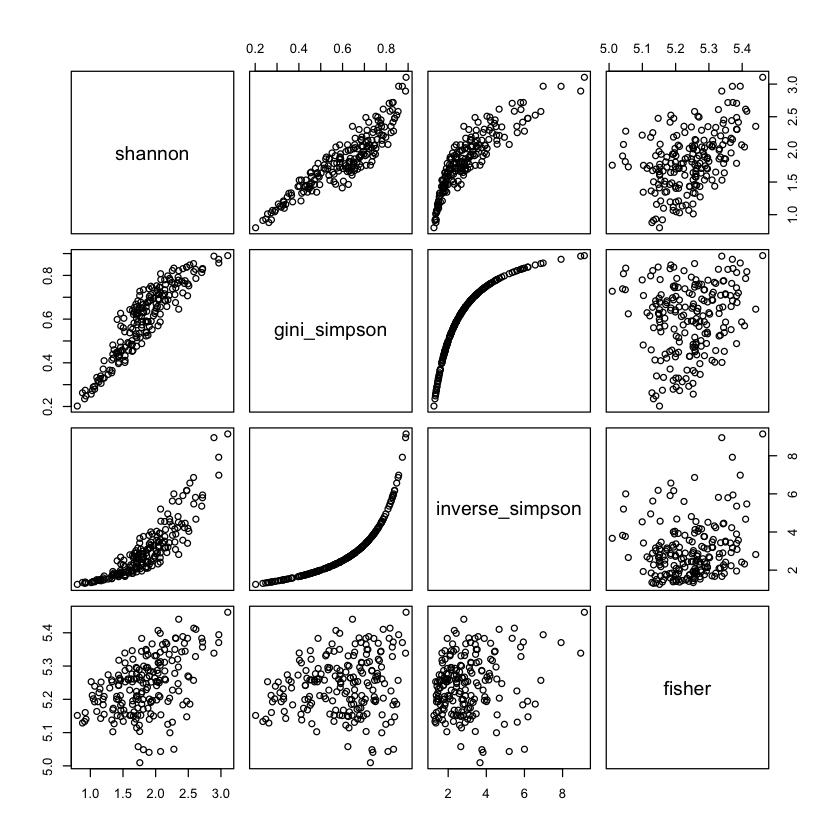

,shannon,gini_simpson,inverse_simpson,fisher
shannon,1.0000000,0.9164825,0.8751894,0.4663436
gini_simpson,0.9164825,1.0000000,0.8733146,0.1690172
inverse_simpson,0.8751894,0.8733146,1.0000000,0.1793258
fisher,0.4663436,0.1690172,0.1793258,1.0000000


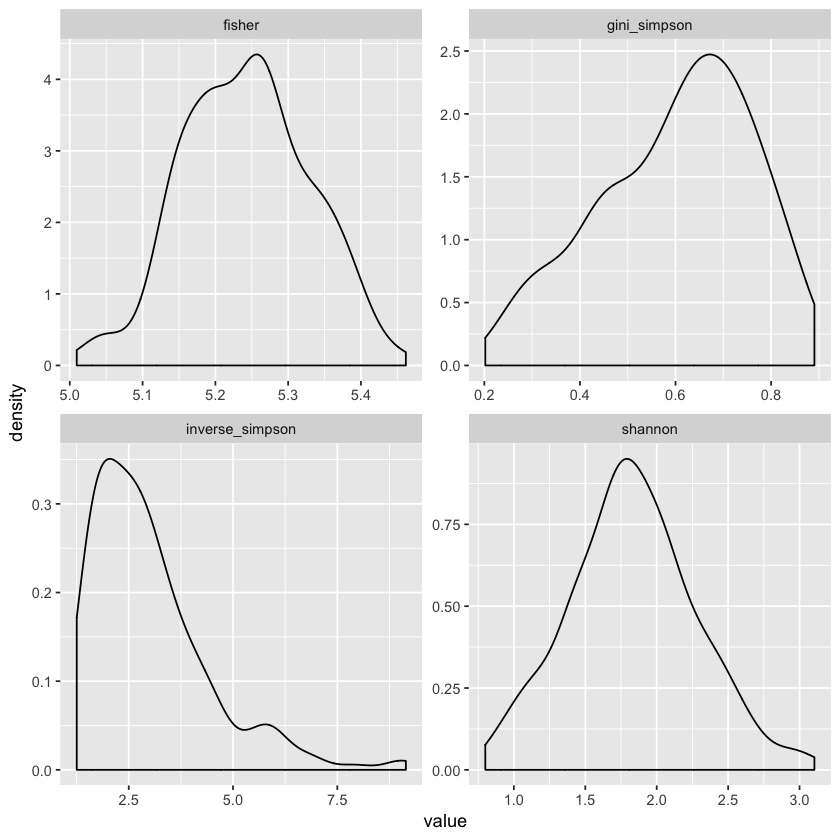

In [49]:
data %>% 
    select(shannon, gini_simpson, inverse_simpson, fisher) %>%
    pairs()

data %>% 
    select(shannon, gini_simpson, inverse_simpson, fisher) %>%
    gather(index, value) %>%
    ggplot(aes(value)) +
    geom_density() +
    facet_wrap(~index, scales = "free")

data %>% 
    select(shannon, gini_simpson, inverse_simpson, fisher) %>%
    cor()

In [50]:
folder <- here("models/alpha_diversity")
diversity_index <- c("shannon", "inverse_simpson", "gini_simpson")

### Model specification
I will define different models using either gaussian or skew_normal distribution and also using either the integrated missing value treatment from BRMS or not. The rationale behind using it is that I will have more power to evaluate the hypotheses whether CC has effect on MB. Breastfeeding is a covariate and the uncertainty introduced imputation will be reflected in the posterior. 

The skew_normal should better be able to deal with the inverse simpson but in the end both should be fine.

In [51]:
# # create directories
# lapply(diversity_index, function(x) {
#     dir.create(glue("{folder}/{x}"))
#     dir.create(glue("{folder}/{x}/gaussian"))
#     dir.create(glue("{folder}/{x}/skew_normal"))
# })

In [52]:
prior <- 
    c(
        set_prior("normal(0, 1)", class = "b"),
        set_prior("exponential(20)", class = "sd"),
        set_prior("normal(0, 10)", class = "Intercept"),
        set_prior("lkj(2)", class = "cor")
    )
prior_skew <- 
    c(
        set_prior("normal(0, 1)", class = "b"),
        set_prior("exponential(25)", class = "sd"),
        set_prior("normal(0, 10)", class = "Intercept"),
        set_prior("lkj(2)", class = "cor")
    )
brm_div <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/{diversity_index}/gaussian/full")
        #fit model
        brm(
            family = gaussian(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15),
            prior = prior, file = model_file
        )
}


brm_div_multiple <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/{diversity_index}/gaussian/full_multiple")
        #fit model
        brm_multiple(
            family = gaussian(), data = data_imp, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15),
            prior = prior, file = model_file
        )
}

brm_div_multiple_comp <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + sibling * csection + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/{diversity_index}/gaussian/multiple_comp")
        #fit model
        brm_multiple(
            family = gaussian(), data = data_imp, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15),
            prior = prior, file = model_file
        )
}

brm_div_multiple_skew <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/{diversity_index}/skew_normal/full_multiple_skew")
        #fit model
        brm_multiple(
            family = skew_normal(), data = data_imp, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15),
            prior = prior_skew, file = model_file
        )
}


brm_div_mi <- function(diversity_index) {
        # delete _ for prior
        div_prior <- gsub("_", "", diversity_index)
        # specify prior for mi version
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = div_prior),
            set_prior("exponential(15)", class = "sd", resp = div_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = div_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(15)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
        )
        # formula
        f1 <- as.formula(glue("{diversity_index} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
        f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {diversity_index} + age_d_s + (1 + time + age_d_s + {diversity_index}|subject_id)"))
        formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
        model_file <- glue("{folder}/{diversity_index}/gaussian/full_mi")
        #fit model
        brm(
            family = gaussian(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15), 
            prior = prior_n, file = model_file
        )
}

brm_div_skew <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/{diversity_index}/skew_normal/full")
        #fit model
        brm(
            family = skew_normal(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999), 
            prior = prior, file = model_file
        )
}


brm_div_skew_mi <- function(diversity_index) {
        # delete _ for prior
        div_prior <- gsub("_", "", diversity_index)
        # specify prior 
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = div_prior),
            set_prior("exponential(15)", class = "sd", resp = div_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = div_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(15)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts"))
        # formula
        f1 <- as.formula(glue("{diversity_index} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
        f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {diversity_index} + age_d_s + (1 + time + age_d_s + {diversity_index}|subject_id)"))
        formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
        model_file <- glue("{folder}/{diversity_index}/skew_normal/full_mi")
        #fit model
        brm(
            family = skew_normal(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15), 
            prior = prior_n, file = model_file
        )
}

In [53]:
glue("{folder}/{diversity_index}/gaussian/multiple_comp")

/Users/henrikeckermann/workspace/research_master/minor_research_project/article/analyses/bibo/models/alpha_diversity/shannon/gaussian/multiple_comp
/Users/henrikeckermann/workspace/research_master/minor_research_project/article/analyses/bibo/models/alpha_diversity/inverse_simpson/gaussian/multiple_comp
/Users/henrikeckermann/workspace/research_master/minor_research_project/article/analyses/bibo/models/alpha_diversity/gini_simpson/gaussian/multiple_comp

In [54]:
#pp_div_m_skew <- future_map2(div_models_m_skew, diversity_index, ~pp_plot(.x, 10, .y))
#pp_div_m_v2_skew <- future_map2(div_models_m_skew, diversity_index, ~pp_plot_v2(.x, 10, .y))
#pp_div_m_skew
#pp_div_m_v2_skew

In [55]:
#pp_div_m <- future_map2(div_models_m, diversity_index, ~pp_plot(.x, 10, .y))
#pp_div_m_v2 <- future_map2(div_models_m, diversity_index, ~pp_plot_v2(.x, 10, .y))
#pp_div_m
#pp_div_m_v2

In [56]:
# use this for brm multiple
calc_treatment_effect_div <- function(div, summarise = TRUE, stat = "mean") {
    model <- brm_div_multiple_skew(div)
    df <- posterior_samples(model) %>%
        select(
            glue("b_Intercept"), 
            glue("b_ccyes"), 
            glue("b_timepost"), 
            glue("b_ccyes:timepost"),
            alpha, sigma) %>%
        rename(
            noccpre = glue("b_Intercept"), 
            ccpre = glue("b_ccyes"),
            noccpost = glue("b_timepost"),
            ccpost = glue("b_ccyes:timepost")) %>%
        mutate(
            ccpost = noccpre + ccpre + noccpost + ccpost,
            noccpost = noccpre + noccpost,
            ccpre = noccpre + ccpre)   %>%
    select(noccpre, ccpre, noccpost, ccpost, alpha, sigma)
    if (summarise) {
        df <- df %>% gather(group, value) %>%
            group_by(group) %>%
            do(data.frame(
                central = ifelse(stat == "median", median(.$value), mean(.$value)),
                lower = hpdi(.$value)[1],
                upper = hpdi(.$value)[2]
            ))
    }
    df
}


# use this for brm multiple shannnon
calc_treatment_effect_shannon <- function(div = "shannon", summarise = TRUE, stat = "mean") {
    model <- brm_div_multiple(div)
    df <- posterior_samples(model) %>%
        select(
            glue("b_Intercept"), 
            glue("b_ccyes"), 
            glue("b_timepost"), 
            glue("b_ccyes:timepost"),
            glue("b_age_d_s"),
            glue("b_bf_count_s"),
            sigma) %>%
        rename(
            noccpre = glue("b_Intercept"), 
            ccpre = glue("b_ccyes"),
            noccpost = glue("b_timepost"),
            ccpost = glue("b_ccyes:timepost"),
            age = glue("b_age_d_s"),
            bf = glue("b_bf_count_s")
        ) %>%
        mutate(
            ccpost = noccpre + ccpre + noccpost + ccpost,
            noccpost = noccpre + noccpost,
            ccpre = noccpre + ccpre)   %>%
    select(noccpre, ccpre, noccpost, ccpost, age, bf, sigma)
    if (summarise) {
        df <- df %>% gather(group, value) %>%
            group_by(group) %>%
            do(data.frame(
                central = ifelse(stat == "median", median(.$value), mean(.$value)),
                lower = hpdi(.$value)[1],
                upper = hpdi(.$value)[2]
            ))
    }
    df
}

# use this for brm multiple shannnon
calc_treatment_effect_comp <- function(div = div, summarise = TRUE, stat = "mean") {
    model <- brm_div_multiple_comp(div)
    df <- posterior_samples(model) %>%
        select(
            glue("b_Intercept"), 
            glue("b_ccyes"), 
            glue("b_timepost"), 
            glue("b_ccyes:timepost"),
            glue("b_age_d_s"),
            glue("b_bf_count_s"),
            glue("b_sibling1"),
            glue("b_csection1"),
            glue("b_sibling1:csection1"),
            sigma) %>%
        rename(
            noccpre = glue("b_Intercept"), 
            ccpre = glue("b_ccyes"),
            noccpost = glue("b_timepost"),
            ccpost = glue("b_ccyes:timepost"),
            age = glue("b_age_d_s"),
            bf = glue("b_bf_count_s"),
            sibling = glue("b_sibling1"),
            csection = glue("b_csection1"),
            "csection:sibling" = glue("b_sibling1:csection1"),
        ) %>%
        mutate(
            ccpost = noccpre + ccpre + noccpost + ccpost,
            noccpost = noccpre + noccpost,
            ccpre = noccpre + ccpre)   %>%
    select(noccpre, ccpre, noccpost, ccpost, age, bf, sibling, csection, "csection:sibling", sigma)
    if (summarise) {
        df <- df %>% gather(group, value) %>%
            group_by(group) %>%
            do(data.frame(
                central = ifelse(stat == "median", median(.$value), mean(.$value)),
                lower = hpdi(.$value)[1],
                upper = hpdi(.$value)[2]
            ))
    }
    df
}


In [57]:
compare_groups_div <- function(div) {
    df <- calc_treatment_effect_div(div, summarise = F)
    df <- df %>% 
        mutate(            
            ccpost_ccpre = ccpost - ccpre,
            ccpost_noccpost = ccpost - noccpost,
            ccpre_noccpre = ccpre - noccpre,
            noccpost_noccpre = noccpost - noccpre) %>%
        select(ccpost_ccpre, ccpost_noccpost, ccpre_noccpre, noccpost_noccpre, alpha, sigma) %>%
        gather(comparison, value) %>%
        group_by(comparison) %>%
        do(data.frame(
            mean_diff = mean(.$value),
            lower = hpdi(.$value)[1],
            upper = hpdi(.$value)[2],
            prob = mean(.$value < 0), 
            index = div
        ))
    df
}

compare_groups_shannon <- function(div = "shannon") {
    df <- calc_treatment_effect_shannon(div, summarise = F)
    df <- df %>% 
        mutate(            
            ccpost_ccpre = ccpost - ccpre,
            ccpost_noccpost = ccpost - noccpost,
            ccpre_noccpre = ccpre - noccpre,
            noccpost_noccpre = noccpost - noccpre) %>%
        select(ccpost_ccpre, ccpost_noccpost, ccpre_noccpre, noccpost_noccpre, age, bf, sigma) %>%
        gather(comparison, value) %>%
        group_by(comparison) %>%
        do(data.frame(
            mean_diff = mean(.$value),
            lower = hpdi(.$value)[1],
            upper = hpdi(.$value)[2],
            prob = mean(.$value < 0), 
            index = div
        ))
    df
}

compare_groups_comp <- function(div = "shannon") {
    df <- calc_treatment_effect_comp(div, summarise = F)
    df <- df %>% 
        mutate(            
            ccpost_ccpre = ccpost - ccpre,
            ccpost_noccpost = ccpost - noccpost,
            ccpre_noccpre = ccpre - noccpre,
            noccpost_noccpre = noccpost - noccpre) %>%
        select(ccpost_ccpre, ccpost_noccpost, ccpre_noccpre, noccpost_noccpre, age, bf, sibling, csection, "csection:sibling", sigma) %>%
        gather(comparison, value) %>%
        group_by(comparison) %>%
        do(data.frame(
            mean_diff = mean(.$value),
            lower = hpdi(.$value)[1],
            upper = hpdi(.$value)[2],
            prob = mean(.$value < 0), 
            index = div
        ))
    df
}

In [58]:
#df_div <- map(diversity_index, calc_treatment_effect_div, FALSE)
#df_sum_div <- map(diversity_index, calc_treatment_effect_div, TRUE)

#df_shannon <- calc_treatment_effect_shannon("shannon", FALSE)
#df_sum_shannon <- calc_treatment_effect_shannon("shannon", TRUE)

In [59]:
#df_div %>% head()
#comparison_div <- map(diversity_index, compare_groups_div)
#comparison_shannon <- compare_groups_shannon("shannon")
comparison_comp <- compare_groups_comp("shannon")

In [60]:
comparison_comp

comparison,mean_diff,lower,upper,prob,index
age,0.0716693107,-0.04233854,0.191123009,0.113575,shannon
bf,-0.0652484727,-0.13326072,0.003637073,0.967950,shannon
ccpost_ccpre,-0.2384897299,-0.46221006,-0.017577278,0.981600,shannon
ccpost_noccpost,-0.2477357536,-0.42260717,-0.069258813,0.996175,shannon
ccpre_noccpre,-0.0004546708,-0.17416367,0.175185868,0.502950,shannon
csection,0.4528927149,0.14717558,0.765050018,0.002150,shannon
csection:sibling,-0.0350933030,-0.47336467,0.417707736,0.559900,shannon
noccpost_noccpre,0.0087913528,-0.21650912,0.225259164,0.469950,shannon
sibling,-0.0896291620,-0.24266584,0.055830954,0.882175,shannon
sigma,0.3323700802,0.27490319,0.397742190,0.000000,shannon


In [61]:
#diversity_comparisons <- comparison_div %>% 
#    map_df(bind_rows) %>%
#    mutate_if(is.numeric, round, 3) %>%
#    as_tibble() %>%
#    mutate(comparison = ifelse(comparison == 'ccpost_ccpre', "CC_POST - CC_PRE",
#                               ifelse(comparison == 'ccpost_noccpost', "CC_POST - HOME_POST",
#                                                    ifelse(comparison == 'ccpre_noccpre', "CC_PRE - HOME_PRE", 
#                                                           ifelse(comparison == 'ccpre_noccpre', "CC_PRE - HOME_PRE",
#                                                                  ifelse(comparison == "noccpost_noccpre", "HOME_POST - HOME_PRE", 
#                                                                         ifelse(comparison == "alpha", "Alpha", "Sigma")))))))
#shannon_comparisons <- comparison_shannon %>%
#    mutate_if(is.numeric, round, 3) %>%
#    as_tibble() %>%
#    mutate(comparison = ifelse(comparison == 'ccpost_ccpre', "CC_POST - CC_PRE",
#                               ifelse(comparison == 'ccpost_noccpost', "CC_POST - HOME_POST",
#                                                    ifelse(comparison == 'ccpre_noccpre', "CC_PRE - HOME_PRE", 
#                                                           ifelse(comparison == 'ccpre_noccpre', "CC_PRE - HOME_PRE",
#                                                                  ifelse(comparison == "noccpost_noccpre", "HOME_POST - HOME_PRE", str_to_title(comparison)))))))

comp_comparisons <- comparison_comp %>%
    mutate_if(is.numeric, round, 3) %>%
    as_tibble() %>%
    mutate(comparison = ifelse(comparison == 'ccpost_ccpre', "CCPOST - CCPRE",
                               ifelse(comparison == 'ccpost_noccpost', "CCPOST - HOMEPOST",
                                                    ifelse(comparison == 'ccpre_noccpre', "CCPRE - HOMEPRE", 
                                                           ifelse(comparison == 'ccpre_noccpre', "CCPRE - HOMEPRE",
                                                                  ifelse(comparison == "noccpost_noccpre", "HOME_POST - HOME_PRE", str_to_title(comparison)))))))
#diversity_comparisons
#shannon_comparisons
comp_comparisons

comparison,mean_diff,lower,upper,prob,index
Age,0.072,-0.042,0.191,0.114,shannon
Bf,-0.065,-0.133,0.004,0.968,shannon
CCPOST - CCPRE,-0.238,-0.462,-0.018,0.982,shannon
CCPOST - HOMEPOST,-0.248,-0.423,-0.069,0.996,shannon
CCPRE - HOMEPRE,0.000,-0.174,0.175,0.503,shannon
Csection,0.453,0.147,0.765,0.002,shannon
Csection:sibling,-0.035,-0.473,0.418,0.560,shannon
HOME_POST - HOME_PRE,0.009,-0.217,0.225,0.470,shannon
Sibling,-0.090,-0.243,0.056,0.882,shannon
Sigma,0.332,0.275,0.398,0.000,shannon


In [62]:
data %>% filter(time == "pre") %>% group_by(sibling, csection) %>% summarise(n = n())

sibling,csection,n
0,0,35
0,1,5
1,0,51
1,1,4
1,NA,2
NA,0,1


In [63]:
#colnames(diversity_comparisons) <- c("Parameter", "Mean", "Lower", "Upper", "P(Parameter < 0)", "Index")
#colnames(shannon_comparisons) <- c("Parameter", "Mean", "Lower", "Upper", "P(Parameter < 0)", "Index")
colnames(comp_comparisons) <- c("Parameter", "Mean", "Lower", "Upper", "P(Parameter < 0)", "Index")
#diversity_comparisons <- diversity_comparisons %>%
#    mutate("95% HPDI" = glue("[{Lower}, {Upper}]")) %>%
#    select(Parameter, Mean, "95% HPDI", "P(Parameter < 0)", Index) %>%
#    group_by(Index) %>% nest()
#shannon_comparisons <- shannon_comparisons %>%
#    mutate("95% HPDI" = glue("[{Lower}, {Upper}]")) %>%
#    select(Parameter, Mean, "95% HPDI", "P(Parameter < 0)", -Index)
comp_comparisons <- comp_comparisons %>%
    mutate("95% HPDI" = glue("[{Lower}, {Upper}]")) %>%
    select(Parameter, Mean, "95% HPDI", "P(Parameter < 0)", -Index)

In [64]:
comp_comparisons <- comp_comparisons %>% 
    add_column(sort = c(5, 6, 1, 2, 3, 7, 9, 4, 8, 10)) %>%
    arrange(sort) %>% 
    select(-sort)

In [66]:
# # change group names for plotting
# data <- data %>% mutate(
#     group = ifelse(groups == "noCCpost", "noccpost", ifelse(groups == "CCpost", "ccpost", ifelse(groups == "CCpre", "ccpre", "noccpre"))))
# # visualize difference
# plot_effects <- function(div, df_div, data = data) {
#     title = gsub("_", " ", div)
#     title = str_to_title(title)
#     #df_div_gathered <- df_div %>% gather(group, value)
#     df_div_gathered <- df_div %>% 
#         select(-alpha, -sigma) %>%
#         gather(group, value) %>%
#         group_by(group) %>%
#         summarise(mean = mean(value), lower = hpdi(value)[1], upper = hpdi(value)[2])
#     data %>% mutate(subject_id = as.factor(subject_id)) %>%
#     ggplot(aes_string("group", div, group = "subject_id")) +
#         geom_point(alpha = 0.5, size = 3) +
#         geom_path(alpha = 0.3, size = 1) +
#         geom_errorbar(data = df_div_gathered, aes(x = group, y = mean, ymin = lower, ymax = upper, group = ""), color = "#ca0020", size = 2) +
#         #geom_jitter(data = df_div_gathered, aes(x = group, y = value, group = ""), width = 0.05, alpha = 0.01, color = "#ef8a62") +
#         scale_x_discrete(limits=c("noccpre", "noccpost", "ccpre", "ccpost"), labels = c("HOME PRE", "HOME POST", "CC PRE", "CC POST")) +
#         ylab(title) + xlab("") +
#         theme_bw()
# }
# p_div <- map2(diversity_index, df_div, plot_effects, data)

In [68]:
# # change group names for plotting
# data <- data %>% mutate(
#     group = ifelse(groups == "noCCpost", "noccpost", ifelse(groups == "CCpost", "ccpost", ifelse(groups == "CCpre", "ccpre", "noccpre"))))
# # visualize difference
# plot_effects <- function(div, df_div, data = data) {
#     title = gsub("_", " ", div)
#     title = str_to_title(title)
#     #df_div_gathered <- df_div %>% gather(group, value)
#     df_div_gathered <- df_div %>% 
#         select(-sigma) %>%
#         gather(group, value) %>%
#         group_by(group) %>%
#         summarise(mean = mean(value), lower = hpdi(value)[1], upper = hpdi(value)[2])
#     data %>% mutate(subject_id = as.factor(subject_id)) %>%
#     ggplot(aes_string("group", div, group = "subject_id")) +
#         geom_point(alpha = 0.5, size = 3) +
#         geom_path(alpha = 0.3, size = 1) +
#         geom_errorbar(data = df_div_gathered, aes(x = group, y = mean, ymin = lower, ymax = upper, group = ""), color = "#ca0020", size = 2) +
#         #geom_jitter(data = df_div_gathered, aes(x = group, y = value, group = ""), width = 0.05, alpha = 0.01, color = "#ef8a62") +
#         scale_x_discrete(limits=c("noccpre", "noccpost", "ccpre", "ccpost"), labels = c("HOME PRE", "HOME POST", "CC PRE", "CC POST")) +
#         ylab(title) + xlab("") +
#         theme_bw()
# }
# 
# p_shannon <- plot_effects("shannon", df_shannon, data = data)
# p_shannon

In [69]:
df_comp <- calc_treatment_effect_comp("shannon", FALSE)
#df_sum_comp <- calc_treatment_effect_comp("shannon", TRUE)

Warning message:
“Ignoring unknown aesthetics: y”

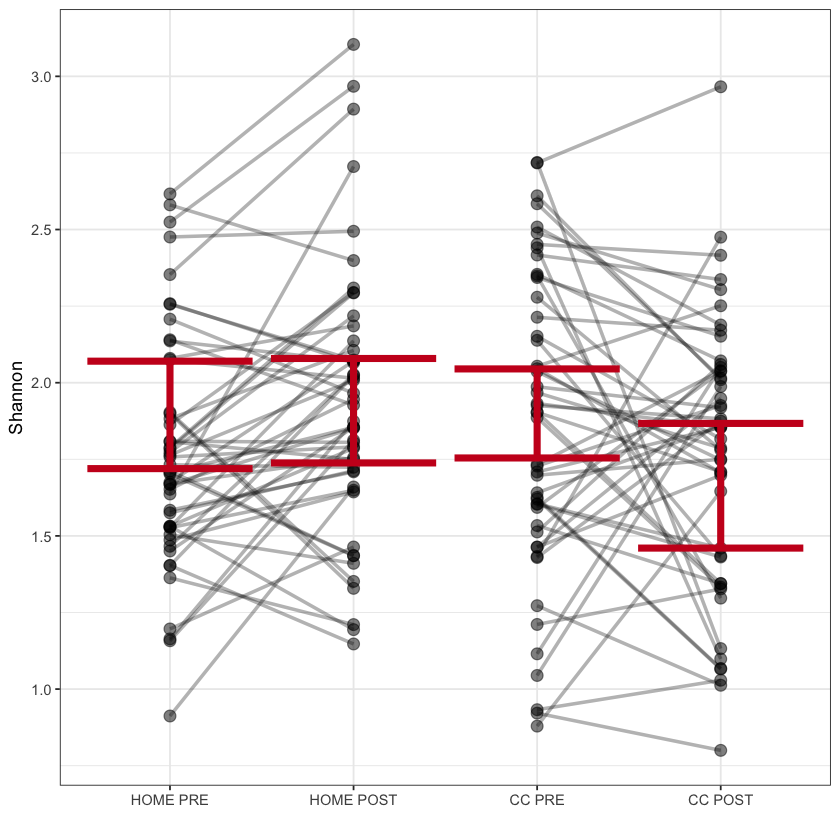

In [70]:
# change group names for plotting
data <- data %>% mutate(
    group = ifelse(groups == "noCCpost", "noccpost", ifelse(groups == "CCpost", "ccpost", ifelse(groups == "CCpre", "ccpre", "noccpre"))))
# visualize difference
plot_effects <- function(div, df_div, data = data) {
    title = gsub("_", " ", div)
    title = str_to_title(title)
    #df_div_gathered <- df_div %>% gather(group, value)
    df_div_gathered <- df_div %>% 
        select(-sigma, -bf, -age, -sibling, -csection, -"csection:sibling") %>%
        gather(group, value) %>%
        group_by(group) %>%
        summarise(mean = mean(value), lower = hpdi(value)[1], upper = hpdi(value)[2])
    data %>% mutate(subject_id = as.factor(subject_id)) %>%
    ggplot(aes_string("group", div, group = "subject_id")) +
        geom_point(alpha = 0.5, size = 3) +
        geom_path(alpha = 0.3, size = 1) +
        geom_errorbar(data = df_div_gathered, aes(x = group, y = mean, ymin = lower, ymax = upper, group = ""), color = "#ca0020", size = 2) +
        #geom_jitter(data = df_div_gathered, aes(x = group, y = value, group = ""), width = 0.05, alpha = 0.01, color = "#ef8a62") +
        scale_x_discrete(limits=c("noccpre", "noccpost", "ccpre", "ccpost"), labels = c("HOME PRE", "HOME POST", "CC PRE", "CC POST")) +
        ylab(title) + xlab("") +
        theme_bw()
}

p_comp <- plot_effects("shannon", df_comp, data = data)
p_comp


# Differential abundance testing

In [72]:
# specify prior (i did not specifiy sigma and alpha)
prior <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("lkj(2)", class = "cor"))
prior_refit <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(55)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("lkj(2)", class = "cor"))
prior_refit2 <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(65)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("lkj(2)", class = "cor"))

prior_refit3 <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(75)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("lkj(2)", class = "cor"))

prior_refit4 <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(100)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("lkj(2)", class = "cor"))


control <-  list(adapt_delta = 0.9999, max_treedepth = 15)
folder <- here("models/differential_abundance/skew_normal/mice/")

# define fitting function for fixed sigma for mice object
brm_sn <- function(genus) {
    # specify formula
    f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + (1+ time + age_d_s + bf_count_s|subject_id)"))
    formula <- bf(f_d)
    # give individual model name for storage
    model_file <- glue("{folder}/{genus}_full_multiple")
    #fit model
    brm_multiple(
        family = skew_normal(), data = data_imp, formula = formula,
        chains = 4, warmup = 1000,
        control = control, prior = prior, file = model_file
        )
    
}

brm_sn_multiple_fut <- function(genus) future({
    tryCatch(
        {
            # specify formula
            f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + (1+ time + age_d_s + bf_count_s|subject_id)"))
            formula <- bf(f_d)
            # give individual model name for storage
            model_file <- glue("{folder}/{genus}_full_multiple")
            #fit model
            brm_multiple(
                family = skew_normal(), data = data_imp, formula = formula,
                chains = 4, warmup = 1000,
                control = control, prior = prior, file = model_file
                )
        },
        error=function(cond) {
            # Choose a return value in case of error
            return(cond)
        }
    )
})

brm_sn_multiple_fut_refit <- function(genus) future({
    tryCatch(
        {
            # specify formula
            f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + (1+ time + age_d_s + bf_count_s|subject_id)"))
            formula <- bf(f_d)
            # give individual model name for storage
            model_file <- glue("{folder}/refit/{genus}_full_multiple")
            #fit model
            brm_multiple(
                family = skew_normal(), data = data_imp, formula = formula,
                chains = 4, warmup = 1000,
                control = control, prior = prior_refit4, file = model_file
                )
        },
        error=function(cond) {
            # Choose a return value in case of error
            return(cond)
        }
    )
})

brm_sn_multiple_fut_csection <- function(genus) future({
    tryCatch(
        {
            # specify formula
            f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + csection + (1+ time + age_d_s + bf_count_s|subject_id)"))
            formula <- bf(f_d)
            # give individual model name for storage
            model_file <- glue("{folder}/{genus}_full_multiple_csection")
            #fit model
            brm_multiple(
                family = skew_normal(), data = data_imp, formula = formula,
                chains = 4, warmup = 1000,
                control = control, prior = prior, file = model_file
                )
        },
        error=function(cond) {
            # Choose a return value in case of error
            return(cond)
        }
    )
})


brm_sn_multiple_fut_comp <- function(genus) future({
    tryCatch(
        {
            # specify formula
            f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + csection * sibling + (1+ time + age_d_s + bf_count_s|subject_id)"))
            formula <- bf(f_d)
            # give individual model name for storage
            model_file <- glue("{folder}csection/{genus}_full_multiple_comp")
            #fit model
            brm_multiple(
                family = skew_normal(), data = data_imp, formula = formula,
                chains = 4, warmup = 1000,
                control = control, prior = prior, file = model_file
                )
        },
        error=function(cond) {
            # Choose a return value in case of error
            return(cond)
        }
    )
})

# define fitting function for fixed sigma and imputation on the fly
brm_sn <- function(genus) {
    # specify formula
    f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + (1+ time + age_d_s + bf_count_s|subject_id)"))
    formula <- bf(f_d)
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_full")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula,
        chains = 4, warmup = 1000,
        control = control, prior = prior, file = model_file
        )
    
}
        
        
# define fitting function for fixed sigma
brm_sn_mi <- function(genus) {
        # delete _ for prior
        sub_prior <- gsub("_", "", genus)
        sub_prior <- gsub("\\.", "", sub_prior)
        # specify prior for mi version
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = sub_prior),
            set_prior("exponential(25)", class = "sd", resp = sub_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = sub_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(25)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
        )
    # specify formula
    f1 <- as.formula(glue("{genus} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
    f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {genus} + age_d_s + (1 + time + age_d_s + {genus}|subject_id)"))
    formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_full_mi")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula,
        chains = 4, warmup = 1000,
        control = control, prior = prior_n, file = model_file
        )
    
}
     

        
        
# specify prior 
prior_d <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"), 
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(25)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma"),
            set_prior("lkj(2)", class = "cor"))


control <-  list(adapt_delta = 0.9999, max_treedepth = 15)
# folder 
folder_d <- here("models/cc_vs_nocc")

# define fitting function distributional
brmd_sn <- function(genus) {
    # specify formula
    f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + (1+ time + age_d_s + bf_count_s|subject_id)"))
    formula_d <- bf(f_d, sigma ~ 1 + time*cc + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id))
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_d_full")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula_d,
        chains = 4, warmup = 1000,
        control = control, prior = prior_d, file = model_file
        )
    
}

# define fitting function distributional + mi
brmd_sn_mi <- function(genus) {
    # delete _ for prior
    sub_prior <- gsub("_", "", genus)
    sub_prior <- gsub("\\.", "", sub_prior)
    # specify prior for mi version
    prior_n <- c(
        set_prior("normal(0, 2)", class = "b", resp = sub_prior),
        set_prior("exponential(15)", class = "sd", resp = sub_prior),
        set_prior("normal(0, 10)", class = "Intercept", resp = sub_prior), 
        set_prior("lkj(2)", class = "cor"),     
        set_prior("normal(0, 2)", class = "b", dpar = "sigma", resp = sub_prior),
        set_prior("exponential(25)", class = "sd", dpar = "sigma", resp = sub_prior),
        set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma", resp = sub_prior),
        set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
        set_prior("exponential(15)", class = "sd", resp = "bfcounts"),
        set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
    )
    # specify formula
    f1 <- as.formula("Enterococcus |mi() ~ 1+ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)")
    f1 <- bf(f1, sigma ~ 1 + time*cc + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id))
    f2 <- as.formula("bf_count_s |mi() ~ 1 + cc*time + Enterococcus + age_d_s + (1 + time + age_d_s + Enterococcus|subject_id)")
    formula_d <- bf(f1) + bf(f2) + set_rescor(FALSE) 
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_d_full_mi")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula_d,
        chains = 4, warmup = 1000,
        control = control, prior = prior_n, file = model_file
        )
    
}

# this function I added for the exluded_id (see below)
# define fitting function for fixed sigma
brm_sn_mi_ex <- function(genus) {
        # delete _ for prior
        sub_prior <- gsub("_", "", genus)
        sub_prior <- gsub("\\.", "", sub_prior)
        # specify prior for mi version
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = sub_prior),
            set_prior("exponential(35)", class = "sd", resp = sub_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = sub_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(35)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
        )
    # specify formula
    f1 <- as.formula(glue("{genus} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
    f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {genus} + age_d_s + (1 + time + age_d_s + {genus}|subject_id)"))
    formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_full_mi")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula,
        chains = 4, warmup = 1000,
        control = control, prior = prior_n, file = model_file
        )
    
}

In [73]:
#plan(multiprocess)
#map(files[excluded_ids], brm_sn_multiple_fut_refit)
#models <- future_map(models_fut, value)

In [ ]:
plan(multiprocess)
selection <- c(
    "Granulicatella", 
    "Enterococcus", 
    "Streptococcusintermediusetrel", 
    "Streptococcusbovisetrel", 
    "Streptococcusmitisetrel", 
    "Bifidobacterium"
)
genus_leftover <- genus[!genus %in% selection]
models_fut <- map(genus_leftover, brm_sn_multiple_fut_comp)
#models <- map(models_fut, value)

In [ ]:
#refit_gs <- gsub("_full_multiple.rds", "", list.files(here("models/differential_abundance/skew_normal/mice/refit")))

In [ ]:
#for (genus in converged_models[excluded_ids]) {
#    fit_fut <- brm_sn_multiple_fut(genus)
#    fit <- values(fit_fut)
#    print(summary(fit))
#}

In [ ]:
#map(refit_gs, ~file.remove(here(glue("models/differential_abundance/skew_normal/mice/{.x}_full_multiple.rds"))))
#map(genus_refit[excluded_ids], ~file.remove(here(glue("models/differential_abundance/skew_normal/mice/{.x}"))))

In [ ]:
converged_models <- list.files(here(glue("models/differential_abundance/skew_normal/mice/")))
converged_models <- gsub("_full_multiple.rds", "", converged_models)
converged_models <- converged_models[-123]
#converged_models

In [ ]:
# model screening/excluding 
return_diag <- function(fit, genus) {
    sum_fit <- summary(fit)
    params <- rbind(sum_fit$fixed, sum_fit$random$subject_id, sum_fit$spec_pars) %>% as.data.frame()
    # extract n of divergent transitions
    n_divergent <- nuts_params(fit) %>% 
        filter(Parameter == "divergent__") %>% 
        summarise(n = sum(Value))
    # extract n of rhat > 1.1        
    n_high_rhat <- dim(filter(params, Rhat >= 1.1))[1]
    # check if there are rhat > 1.1 or divergent transitions
    if (n_high_rhat > 0) {
        message(glue("{genus} has {n_high_rhat} high Rhat parameter values"))
        return(FALSE)
    } else if (n_divergent$n > 0){
        message(glue("{genus} has {n_divergent$n} divergent transitions"))
        return(FALSE)
    } 
    TRUE
}

calc_mu_diff <- function(model, summarise = TRUE, stat = "mean") {
    df <- posterior_samples(model) %>%
        select(
            glue("b_Intercept"), 
            glue("b_ccyes"), 
            glue("b_timepost"), 
            glue("b_timepost:ccyes"), 
            glue("b_age_d_s"), 
            glue("b_bf_count_s"),
            glue("b_sibling1"),
            glue("b_csection1"),
            glue("b_csection1:sibling1")
        ) %>%
        rename(
            noccpre = glue("b_Intercept"), 
            ccpre = glue("b_ccyes"),
            noccpost = glue("b_timepost"),
            ccpost = glue("b_timepost:ccyes"),
            age = glue("b_age_d_s"),
            bf = glue("b_bf_count_s"),
            csection = glue("b_csection1"),
            sibling = glue("b_sibling1"),
            csection_sibling = glue("b_csection1:sibling1")
        ) %>%
        mutate(
            ccpost = noccpre + ccpre + noccpost + ccpost,
            noccpost = noccpre + noccpost,
            ccpre = noccpre + ccpre
    )    
    if (summarise) {
        df <- df %>% gather(group, value) %>%
            group_by(group) %>%
            do(data.frame(
                central = ifelse(stat == "median", median(.$value), mean(.$value)),
                lower = hpdi(.$value)[1],
                upper = hpdi(.$value)[2]
            ))
        
    }
    df 
}

plot_diff <- function(model) {
    df_sum <- calc_mu_diff(model)
    df <- calc_mu_diff(model, summarise = F)
    # plot
    df %>% gather(group, value) %>%
        ggplot(aes(x = group, value)) +
            geom_jitter(alpha = 0.05, color = "darkred") +
            geom_point(data = df_sum, aes(x = group, y = central), size = 2, color = "red") +
            geom_errorbar(data = df_sum, aes(x = group, y = central,  ymin = lower, ymax = upper), color = "darkred") +
            theme_bw()
}
compare_groups <- function(fit, genus) {
    df <- calc_mu_diff(fit,  summarise = F)
    df <- df %>% 
        mutate(            
            ccpost_ccpre = ccpost - ccpre,
            ccpost_noccpre = ccpost - noccpre,
            ccpost_noccpost = ccpost - noccpost,
            noccpre_ccpre = noccpre - ccpre,
            noccpost_noccpre = noccpost - noccpre,
            noccpost_ccpre = noccpost - ccpre) %>%
        select(ccpost_ccpre, ccpost_noccpre, ccpost_noccpost, noccpre_ccpre, noccpost_noccpre, noccpost_ccpre, age, bf, csection, sibling, csection_sibling) %>%
        gather(comparison, value) %>%
        group_by(comparison) %>%
        do(data.frame(
            mean = mean(.$value),
            lower = hpdi(.$value)[1],
            upper = hpdi(.$value)[2],
            prob = mean(.$value < 0)
        ))
    df %>% add_column(genus = genus)
}

return_comparisons <- function(genus) {
    fit_fut <- brm_sn_multiple_fut_comp(genus)
    fit <- value(fit_fut)
    # can we go on with the model?
    if (!return_diag(fit, genus)) {
        return(genus = NA)
    }
    
    # else go on and compare groups
    compare_groups(fit, genus)
}

In [ ]:
finished <- list.files(here("models/differential_abundance/skew_normal/mice/csection"))
finished <- gsub("_full_multiple_comp.rds", "", finished)
finished %>% length()

In [ ]:
#genus[!genus %in% finished]

In [ ]:
#models_fut <- future_map(genus[!genus %in% finished], brm_sn_multiple_fut_comp)

In [ ]:
#plan(multiprocess)
#comp_all <- future_map(converged_models, return_comparisons)
comp_all_comp <- future_map(finished, return_comparisons)

In [ ]:
# I used this until all models converged
excluded_ids <- which(is.na(comp_all_comp))
#converged_models[excluded_ids]
comp_all_complete <- comp_all_comp[!is.na(comp_all_comp)]
length(comp_all_complete)

In [ ]:
comp_all_df <- map_df(comp_all_complete, bind_rows)
head(comp_all_df, 10)

In [ ]:
# the input for the plot_comp function will be nested dfs:
comp_all_nested <- comp_all_df %>% 
    group_by(comparison) %>%
    nest()

plot_comp <- function(data, comp) {
    all_comp <- data %>% mutate(prob = report_star_nondirectional(prob))
    n_genera <- length(all_comp$genus)
    part1 <- all_comp[1:n_genera/2, ]
    part2 <- all_comp[-c(1:n_genera/2), ]
    p <- map(list(part1, part2), ~ ggplot(
        .x, aes(genus, mean, label = prob)) +
        geom_pointrange(aes(ymin = lower, ymax = upper), size = 0.2) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        geom_text(nudge_y = 1) +
        geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
        ylim(-2, 2) +
        ggtitle(comp) +
        coord_flip() +
        theme_bw(base_size = 8))
    
    p
}


comparison_plots <- map2(comp_all_nested$data, comp_all_nested$comparison, plot_comp)
comparison_plots

In [ ]:
unique(comp_all_df$comparison)

comp_article_1 <- comp_all_df %>% filter(comparison  %in% c("noccpre_ccpre", "ccpost_noccpost"))
comp_article_2 <- comp_all_df %>% filter(comparison  %in% c("ccpost_ccpre", "noccpost_noccpre"))

filter_genus_1 <- comp_article_1 %>% 
    filter((comparison == "noccpre_ccpre" & (prob <= 0.05 | prob >= 0.95)) | (comparison == "ccpost_noccpost" & (prob <= 0.05 | prob >= 0.95)))
filter_genus_2 <- comp_article_2 %>% 
    filter((comparison == "ccpost_ccpre" & (prob <= 0.05 | prob >= 0.95)) | (comparison == "noccpost_noccpre" & (prob <= 0.05 | prob >= 0.95)))

plot_comp_article <- function(data, filter_genus) {
    all_comp <- data %>% mutate(prob = ifelse(prob <= 0.05 | prob >= 0.95, "*", "")) %>%
        filter(genus %in% filter_genus$genus) %>%
        as_tibble()  %>%
        mutate(comparison = ifelse(comparison == 'ccpost_ccpre', "CC_POST - CC_PRE",
                                   ifelse(comparison == 'ccpost_noccpost', "CC_POST - HOME_POST", 
                                          ifelse(comparison == 'ccpost_noccpre', "CC_POST - HOME_PRE", 
                                                 ifelse(comparison == 'ccpre_noccpost', "CC_PRE - HOME_POST", 
                                                        ifelse(comparison == 'ccpre_noccpre', "CC_PRE - HOME_PRE", 
                                                               ifelse(comparison == 'ccpre_noccpre', "CC_PRE - HOME_PRE", "HOME_POST - HOME_PRE"))))))) 
    p <- ggplot(all_comp, aes(genus, mean, label = prob, ymin = lower, ymax = upper, color = prob)) +
        geom_pointrange(size = 1) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        #geom_text(nudge_y = - 0.2, size = 3) +
        geom_hline(yintercept = 0, linetype = "dashed", color = "#404040") +
        scale_color_manual(values = c("#404040", "#ca0020")) +
        ylim(-1.75, 0.75) +
        facet_wrap(~comparison) +
        xlab("") + ylab(bquote(paste("Difference in ", mu))) +
        coord_flip() +
        theme_bw(base_size = 18) +
        theme() +
        theme(legend.position="none")
    
    p
}

comparison_plots_article_1 <- plot_comp_article(comp_article_1, filter_genus_1)
comparison_plots_article_2 <- plot_comp_article(comp_article_2, filter_genus_2)

comparison_plots_article_1
comparison_plots_article_2

In [ ]:
comp_all_df %>% filter(comparison == "csection") %>% arrange(prob)

In [ ]:
unique(comp_all_df$comparison)
comp_article_3 <- comp_all_df %>% filter(comparison %in% c("age", "bf"))
comp_article_4 <- comp_all_df %>% as_tibble() %>% 
    filter(comparison %in% c("csection", "sibling", "csection_sibling")) %>% 
    mutate(comparison = ifelse(comparison == "csection_sibling", "csection:sibling", comparison))

filter_genus_3 <- comp_article_3 %>% 
    filter((comparison == "age" & (prob <= 0.05 | prob >= 0.95)) | (comparison == "bf" & (prob <= 0.05 | prob >= 0.95)))
filter_genus_4 <- comp_article_4 %>% 
    filter((comparison == "csection" & (prob <= 0.05 | prob >= 0.95)) | (comparison == "sibling" & (prob <= 0.05 | prob >= 0.95)) | (comparison == "csection_sibling" & (prob <= 0.05 | prob >= 0.95)))
        
                                    

plot_comp_article <- function(data, filter_genus) {
    all_comp <- data %>% mutate(prob = ifelse(prob <= 0.05 | prob >= 0.95, "*", "")) %>%
        filter(genus %in% filter_genus$genus) %>%
        as_tibble()
    p <- ggplot(all_comp, aes(genus, mean, label = prob, ymin = lower, ymax = upper, color = prob)) +
        geom_pointrange(size = 1) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        #geom_text(nudge_y = - 0.2, size = 3) +
        geom_hline(yintercept = 0, linetype = "dashed", color = "#404040") +
        scale_color_manual(values = c("#404040", "#ca0020")) +
        ylim(-1.35, 1.75) +
        facet_wrap(~comparison) +
        xlab("") + ylab(bquote(paste("Difference in ", mu))) +
        coord_flip() +
        theme_bw(base_size = 18) +
        theme() +
        theme(legend.position="none")
    
    p
}

comparison_plots_article_3 <- plot_comp_article(comp_article_3, filter_genus_3)
comparison_plots_article_4 <- plot_comp_article(comp_article_4, filter_genus_4)

comparison_plots_article_3
comparison_plots_article_4

In [ ]:
library(ggrepel)
mu <- expression(mu)
differential_abundance_plots <- map2(comp_all_nested$data, comp_all_nested$comparison, ~.x %>% 
    arrange(prob) %>% 
    mutate(qvalue = cummean(prob)) %>%
    ggplot(aes(mean, prob, color = ifelse(prob <= 0.025 | prob >= 0.975, "sig", "notsig"), label = ifelse(abs(mean)>= 0.2, genus, ""))) +
        geom_point() + 
        xlim(-1, 1) +
        ggtitle(.y) +
        scale_colour_manual(values = c("sig" = "red", "notsig" = "black")) +
        geom_text_repel() +
        theme_bw() +
        xlab(bquote(paste("Difference in ", mu))) + ylab("P(Difference < 0)") +
        theme(legend.position="none") 
   
   )
#differential_abundance_plots

comp_article <- comp_all_df %>% filter(comparison %in% c("ccpre_noccpre", "ccpost_noccpost", "ccpost_ccpre", "noccpost_noccpre"))

differential_abundance_plots_article <- comp_article %>% 
    arrange(prob) %>% 
    mutate(qvalue = cummean(prob)) %>%
    ggplot(aes(mean, prob, color = ifelse(prob <= 0.05 | prob >= 0.95, "sig", "notsig"), label = ifelse(abs(mean)>= 0.2, genus, ""))) +
        geom_point() + 
        xlim(-1, 1) +
        scale_colour_manual(values = c("sig" = "red", "notsig" = "black")) +
        geom_text_repel(size = 2) +
        facet_wrap(~comparison) +
        theme_bw() +
        theme(legend.position="none") 
differential_abundance_plots[[8]]

In [ ]:
# how often do we find differences per parameter/comparison?
comp_all_df %>%
    filter(prob < 0.025 | prob > 0.975) %>%
    group_by(comparison) %>%
    summarise(n = n())


comp_all_df %>%
    filter(prob < 0.025 | prob > 0.975, abs(mean) >= 0.15, comparison %in% c("ccpre_noccpre", "ccpost_noccpost", "ccpost_ccpre", "noccpost_noccpre", "bf", "age")) %>%
    select(-prob) %>%
    arrange(desc(abs(mean))) %>%
    mutate_if(is.numeric, round, 2)

In [ ]:
# how are the probabilities distributes? In my understanding, if there is no difference between ccpost
# and the other groups, thus the parameter mu is the same, then the probability that group difference is <0 should be close to 50%. 
# If the parameters where not similar but in a non-systematic way, then p should be uniformly distributed ?!
# But if there is a systematic difference I would expect p mostly either < 0.05 or >0.95
comp_all_df %>%
    ggplot(aes(comparison, prob)) +
    geom_violin() +
    geom_jitter(alpha = 0.5, width = 0.05) +
    coord_flip()

comp_all_df %>% 
    ggplot(aes(prob)) +
    geom_density() +
    facet_wrap(~comparison)

In [ ]:
data2 <- data
levels(data2$cc) <- c("HOME", "CC")
levels(data2$cc)
levels(data2$time) <- c("PRE", "POST")
data2 <- data2 %>% 
    select(Age = age_d, everything()) %>% 
    mutate(
        delivery = ifelse(csection == 1, "c-section:yes", ifelse(csection == 0, "c-section:no", csection)),
        sibling = ifelse(
            sibling == 0, "no sibling", ifelse(
                sibling == 1, "at least 1 sibling", sibling))) %>%
    mutate(sibling = as.factor(sibling), csection = as.factor(csection))

In [ ]:
quantile(data2$Bifidobacterium, c(0.25, 0.5, 0.75)) 

In [ ]:
data2 %>% filter(!is.na(sibling) & !is.na(csection)) %>% 
ggplot(aes(sibling, Bifidobacterium)) +
    geom_boxplot() 

data2 %>% filter(!is.na(sibling) & !is.na(csection)) %>% 
ggplot(aes(Bifidobacterium, color = sibling)) +
    geom_density() +
    facet_wrap(~csection)


ggplot(data2, aes(csection, Bifidobacterium, color = sibling)) +
    geom_jitter(width = 0.2, alpha = 0.5) +
    geom_hline(aes(yintercept = c(1, 2)), color = "red")

In [ ]:
# to further understand the difference between age and time and streptococcus etc
csec_sib <- 
    data2 %>% filter(!is.na(sibling) & !is.na(csection)) %>%
    ggplot(aes_string("time", "Bifidobacterium", group = "subject_id", color = "bf_ratio")) +
    geom_point(size = 5) +
    geom_path(size = 1) +
    geom_hline(aes(yintercept = median(data2$Bifidobacterium)), linetype = "dashed", size = 1, color = "#404040") +
    geom_hline(aes(yintercept = quantile(data2$Bifidobacterium, 0.25)), linetype = "dotted", size = 1, color = "#404040") +
    facet_wrap(~sibling*delivery) +
    theme_bw()+
    xlab("") +
    theme_bw(base_size = 30) +
    theme(legend.position = "none") 

csec_sib

abundant_genera <- c("Streptococcusmitisetrel", "Streptococcusbovisetrel", "Streptococcusintermediusetrel", "Granulicatella")
visualize_abundance <- function(genus) {
    ggplot(data2, aes_string("time", genus, group = "subject_id", color = "Age")) +
    geom_point(size = 5) +
    geom_path(size = 1) +
    facet_wrap(~cc) +
    theme_bw()+
    xlab("") +
    theme_bw(base_size = 30) +
    theme(legend.position = "none") 
}
visualize_age_vs_abundance <- function(genus) {
    ggplot(data2, aes_string("Age", genus)) +
    geom_point() +
    geom_smooth() +
    facet_wrap(~cc*time)+
    xlab("")
}
visualize_bf_vs_abundance <- function(genus) {
    ggplot(data2, aes_string("bf_count_s", genus)) +
    geom_point() +
    geom_smooth() +
    facet_wrap(~cc) +
    xlab("")
}
data2$subject_id <-  as.factor(data2$subject_id)
data2$time <-  as.factor(data2$time)
#data2 <- data2 %>% rename(Age = age_d) %>% arrange(subject_id, time)
abundance_paths <- map(abundant_genera, visualize_abundance)
abundance_paths
map(abundant_genera, visualize_age_vs_abundance)
map(abundant_genera, visualize_bf_vs_abundance)





In [ ]:
data %>% group_by(cc, time) %>% summarise(mean(age_d_s), sd(age_d_s))

### Differential abundance LME4

In [ ]:
library(lme4)
library(car)
library(qvalue)

In [ ]:
# change contrasts for easy interpretability
reverse_c <- function(data) {
    contrasts(data$cc)[1, 1] <- 1
    contrasts(data$cc)[2, 1] <- 0
    contrasts(data$time)[1, 1] <- 1
    contrasts(data$time)[2, 1] <- 0
    data
}
data_imp_revc <- map(data_imp, reverse_c)

In [ ]:
# test if it worked
data_imp_revc[[1]]$time %>% contrasts()

In [ ]:
plan(multiprocess)
# fit models and pool estimates
lme4_fits <- 
    future_map(genus[-1], ~ data_imp_revc %>%
      map(lmer, formula = glue("{.x} ~ cc*time + age_d_s + bf_count_s + (1|subject_id)")) %>%
      pool() %>%
      summary() %>%
      rownames_to_column("parameter") %>%
      mutate(parameter = c("intercept", "cc", "time", "age", "breastfeeding", "cc_time")) %>%
      add_column(genus = .x) 
    )

In [ ]:
lme4_by_param <- lme4_fits %>% 
    map_df(bind_rows) %>%
    filter(parameter != "intercept") %>%
    group_by(parameter) %>%
    nest()

In [ ]:
lme4_by_param$parameter

In [ ]:
# calculate q value for each set of parameters, allow for 25% false discoveries
lme4_by_param$data <- map(lme4_by_param$data, ~.x %>% mutate(q = qvalue(p.value)$qvalue))

lme4_final <- lme4_by_param %>% unnest()
lme4_table <- lme4_final %>% 
    filter(p.value<=0.05, q <= 0.2) %>%
    arrange(parameter, desc(abs(estimate))) %>%
    mutate_if(is.numeric, round, 2) %>%
    select(parameter, genus, everything())

In [ ]:
library(ggrepel)

params <- c("cc", "time", "age", "breastfeeding")

plot_comp <- function(comp, data) {
    all_comp <- data %>% mutate(p = report_star(p.value)) %>% filter(parameter == comp)
    n_genera <- length(all_comp$genus)
    part1 <- all_comp[1:n_genera/2, ]
    part2 <- all_comp[-c(1:n_genera/2), ]
    p <- map(list(part1, part2), ~ ggplot(
        .x, aes(genus, estimate, label = p)) +
        geom_pointrange(aes(ymin = estimate - 2*std.error, ymax =estimate + 2*std.error), size = 0.2) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        geom_text(nudge_y = 1) +
        geom_hline(yintercept = 0, linetype = "dashed", color = "blue") +
        ylim(-2, 2) +
        ggtitle(comp) +
        coord_flip() +
        theme_bw(base_size = 8))
    
    p
}

lme4_plots <- map(params, plot_comp, lme4_final)

In [ ]:
library(grid)

#grid.draw(cbind(ggplotGrob(lme4_plots[[1]][[1]]), ggplotGrob(lme4_plots[[1]][[2]]), size = "last"))
grid.draw(cbind(ggplotGrob(lme4_plots[[2]][[1]]), ggplotGrob(lme4_plots[[2]][[2]]), size = "last"))
#grid.draw(cbind(ggplotGrob(lme4_plots[[3]][[1]]), ggplotGrob(lme4_plots[[3]][[2]]), size = "last"))
#grid.draw(cbind(ggplotGrob(lme4_plots[[4]][[1]]), ggplotGrob(lme4_plots[[4]][[2]]), size = "last"))

In [ ]:
lme4_final_table <-  lme4_final
colnames(lme4_final_table) <- str_to_title(colnames(lme4_final_table))
lme4_final_table %>%
    rename(P = P.value) %>%
    filter(P<=0.05, Q <= 0.2) %>%
    arrange(Parameter, desc(abs(Estimate))) %>%
    mutate_if(is.numeric, round, 2) %>%
    select(Parameter, Genus, everything()) 

In [ ]:
str_to_title(colnames(lme4_final_table))
    

### Alpha diversity

In [ ]:
# fit models and pool estimates
lme4_fits_div <- 
    map(diversity_index, ~ data_imp_revc %>%
      future_map(lmer, formula = glue("{.x} ~ cc*time + age_d_s + bf_count_s + (1|subject_id)")) %>%
      pool() %>%
      summary() %>%
      rownames_to_column("parameter") %>%
      mutate(parameter = c("intercept", "cc", "time", "age", "breastfeeding", "cc_time")) %>%
      add_column(index = .x) 
    )

In [ ]:
lme4_by_param_div <- lme4_fits_div %>% 
    map_df(bind_rows) %>%
    filter(parameter != "intercept") %>%
    group_by(parameter) %>%
    nest()

In [ ]:
# calculate q value for each set of parameters, allow for 25% false discoveries
#lme4_by_param_div$data <- map(lme4_by_param_div$data, ~.x %>% mutate(q = qvalue(p.value)$qvalue))
lme4_final_div <- lme4_by_param_div %>% unnest()
lme4_final_div %>%
    arrange(parameter, desc(abs(estimate))) %>%
    mutate_if(is.numeric, round, 2) %>%
    select(parameter, index, everything())

In [ ]:
data %>% 
    group_by(time, cc) %>% 
    summarise(
        shannon = glue("M = {round(mean(shannon), 2)}, SD = {round(sd(shannon), 2)}"),
        inverse_simpson = glue("M = {round(mean(inverse_simpson),2)}, SD = {round(sd(inverse_simpson), 2)}"),
        gini_simpson = glue("M = {round(mean(gini_simpson),2)}, SD = {round(sd(gini_simpson), 2)}")
    )

In [ ]:
save.image(file = here("data/cc_analyses_workspace.RData"))
# save the dataframe for Gerben
saveRDS(data, file = here("data/data_cc.rds"))

In [ ]:
#load(file = here::here("data/cc_analyses_workspace.RData"))

In [ ]:
ggplot(data_transfer, aes(bf_count, ))

## K-means
Just for exercise and curiosity and test if there is clustering

In [ ]:
genus_dist <- otus.clr %>% 
    column_to_rownames("sample_id") %>%
    dist(method = "euclidean")
plot(genus_dist)

In [ ]:
# find optimal number based on SI and elbow method:
si_ss <- map(1:10, function(k) {
    model_si <- cluster::pam(genus_dist, k = k)
    model_ss <- kmeans(genus_dist, centers = k)
    c(k = k, withinss = model_ss$tot.withinss, si =model_si$silinfo$avg.width)
})

In [ ]:
map_df(si_ss, bind_rows) %>%
    gather(index, value, -k) %>%
    na.omit() %>%
    ggplot(aes(k, value)) +
    geom_point() +
    geom_line() +
    scale_x_continuous(breaks = c(0:10)) +
    facet_wrap(~index, scales = "free")

In [ ]:
k_model <- kmeans(genus_dist, center = 2)
k_model$cluster %>% as.data.frame() %>%
    rownames_to_column("sample_id") %>%
    rename(cluster = ".") %>%
    left_join(data, by = "sample_id") %>%
    group_by(cluster, cc, time) %>%
    summarise(n = n())

In [ ]:
pseq.clr2 <- pseq.clr

In [ ]:
k_model <- kmeans(genus_dist, center = 2)
k_model$cluster %>% as.data.frame() %>%
    rownames_to_column("sample_id") %>%
    rename(cluster = ".") %>%
    left_join(data, by = "sample_id") %>%
    select(-contains("PC")) %>%
    df_to_sd() -> sample_data(pseq.clr2)
biplot(pseq.clr2, color = "cluster")

## Further EDA

In [ ]:
data_sub <- data %>% select(sample_id, csection) 
pseq_plot <- pseq.clr
sample_data(pseq_plot) <- sd_to_df(pseq_plot) %>%
    mutate_if(is.numeric, round, 2) %>%
    mutate(sibling = ifelse(sibling == 1, "sibling:yes", ifelse(sibling == 0, "sibling:no", sibling))) %>%
    mutate(sibling = as.factor(sibling), csection = as.factor(csection)) %>%
    df_to_sd()

In [ ]:
data %>% filter(sample_id %in% c("sa_7341", "sa_11210")) %>% select(subject_id, time, cc, age_d_s, bf_ratio, sibling, csection)

In [ ]:
sample_data

In [ ]:
biplot(pseq_plot, connect_series = "time", split_by = "csection",  color = "sibling", loading = 0.32, text = F, textsize = 3, otu_color = "#404040", size = 5)

In [ ]:
biplot(pseq_plot, connect_series = "time", split_by = "sibling",  color = "csection", loading = 0.32, text = F, textsize = 3, otu_color = "#404040")

In [ ]:
biplot(pseq_plot, connect_series = "time", split_by = "csection",  color = "cc", loading = 0.32, text = F, textsize = 3, otu_color = "#404040", shape = "sibling")

In [ ]:
biplot(pseq_plot, color = "sibling", shape = "csection")

In [ ]:
select_csection <- data %>% filter(csection == 1) %>% distinct(sample_id)
biplot(pseq_plot, connect_series = "time", filter_samples = select_csection$sample_id, text = T, label = "bf_ratio", color = "cc", loading = 0.32, alpha = 1, otu_color = "#404040", textsize = 5, textcolor = "black")
data %>% filter(sample_id %in% select_csection$sample_id) %>%
    select(subject_id, sample_id, cc, time, bf_count_s, bf_ratio, sibling)

In [ ]:
# specify prior (i did not specifiy sigma and alpha)
prior <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("lkj(2)", class = "cor"))
control <-  list(adapt_delta = 0.9999, max_treedepth = 15)

# define fitting function for fixed sigma for mice object
brm_sn <- function(genus) {
    # specify formula
    f_d <- as.formula(glue("{genus} ~ 1 + sibling*csection * bf_count_s*time*cc + age_d_s+ (1 + age_d_s+time+ bf_count_s|subject_id)"))
    formula <- bf(f_d)
    # give individual model name for storage
    #fit model
    brm_multiple(
        family = skew_normal(), data = data_imp, formula = formula,
        chains = 4, warmup = 1000,
        control = control, prior = prior
        )
    
}

In [ ]:
tidy(eda_fit) %>% mutate_if(is.numeric, round, 2)

In [ ]:
test <- pp_plot_v2(eda_fit, 10, y_name = "Bifidobacterium")

In [ ]:
test

In [ ]:
dim(otus.clr)

In [ ]:
data %>% group_by(sibling) %>% summarise(n = n())

In [ ]:
data %>%
    ggplot(aes(UnculturedMollicutes, color = as.factor(sibling))) +
    geom_density() +
    xlim(0, 8)

In [ ]:
pcx$rotation %>% as.data.frame() %>%
    rownames_to_column("genus") %>%
    filter(genus %in% c(
        "Bifidobacterium", 
        "Streptococcusmitisetrel", 
        "Streptococcusbovisetrel", 
        "Streptococcusintermediusetrel",
        "Enterococcus",
        "Granulicatella")) %>% select(genus, PC1, PC2, PC3, PC4)

In [ ]:
pcx$rotation %>% as.data.frame() %>%
    rownames_to_column("genus") %>% 
    select(genus, PC1, PC2, PC3, PC4) %>%
    arrange(desc(abs(PC4)))

## new MLM idea

In [39]:
# only use core
core_genus <- core_members(pseq.rel, detection = 0.1/100, 10/100) %>% clean_otu_names()

In [40]:
test_data <- data_imp[[1]] %>%
    select(
        -contains("PC"), 
        -birthweight_s, 
        -age_d, 
        -bf_count, 
        -bf_ratio, 
        -groups, 
        -bf, 
        -ccpost, 
        -childsex, 
        -delivery, 
        -birthweight, 
        -contains("simpson"), 
        -shannon, -fisher, -coverage, -sample_id) %>%
    gather(genus, abundance, -c(subject_id, age_d_s, time, cc, bf_count_s, sibling, csection))

In [47]:
test_data <- test_data %>% 
    filter(genus %in% core_genus) 

In [48]:
save(test_data, file = here("rdata/test_data.rds"))

In [ ]:
test_t <- brm(
    family = student(),
    formula = bf(
        abundance ~ 1 + cc*time + age_d_s + bf_count_s + sibling*csection + 
            (1 + cc*time + age_d_s + bf_count_s + sibling*csection|genus), 
        sigma ~ 1 + genus),
    data = test_data,
    control = list(adapt_delta = 0.95, max_treedepth = 15),
    file = here("rdata/testmodel")
)

Compiling the C++ model
Start sampling


In [ ]:
posterior_samples(test) %>% head()

In [ ]:
print("hi")